# Vacas Saturno Saturninas 🐮🪐
---

El siguiente Collab tiene la función de crear un nuevo dataset con los datos que se nos fue entregando; con el fin de estar trabajando en camino al reto final del socioformador "CAETEC"

Este dataset solo representa a la vaca 1213

Información de contacto
A01711063@tec.mx | 24/10/2025

---
## Proceso EDA del csv - Datos de Ordeña
---

## Funciones Pipeline



# Pipeline `MilkingDataPipeline`

El pipeline `MilkingDataPipeline` está diseñado para limpiar, normalizar y enriquecer datos provenientes de un sistema de ordeño automatizado. Su objetivo es transformar datos crudos en un dataset listo para análisis exploratorio. Evitamos drops agresivos, crea nuevas métricas clave y estandariza nombres y formatos para facilitar el trabajo posterior.

---

## Propósito

Los datos generados por robots de ordeño contienen información crucial sobre producción, tiempos, señales de salud (sangre, conductividad), flujos por cuarto de la ubre y detalles de cada sesión. Sin embargo, suelen venir en formatos desordenados, con columnas confusas, valores nulos y duplicados.

- Normalizar y parsear fechas/hora de ordeño.
- Calcular métricas clave:
  - `dur_min`: duración del ordeño en minutos.
  - `kg_por_min`: producción de leche por minuto (indicador de eficiencia).
- Renombrar columnas del robot para que sean descriptivas.
- Eliminar columnas irrelevantes o ruidosas.
- Crear variables transformadas en log para análisis estadístico.
- Manejar nulos de forma controlada (sin eliminar filas valiosas).
- Dejar un DataFrame limpio, estructurado y listo para análisis o ML.

---

### Columnas a eliminar (`columns_to_drop`)
Se definen varias columnas como irrelevantes para el análisis, por ejemplo:

- `Usuario`
- `Razón de la desviación`
- `Patada`
- `Pezones no encontrados`

Estas columnas no aportan información útil para métricas de eficiencia o modelos predictivos, por lo que se eliminan si existen.

---

### Mapeo de renombre (`rename_mapping`)
El robot suele entregar columnas crípticas (`DI`, `DI.1`, `TI.2`, etc.).  
Este mapeo transforma esos nombres en etiquetas descriptivas como:

- `DI - media de flujos (kg/min)`
- `DD - sangre (ppm)`
- `TI - conductividad (ms/cm)`
- `TD - producciones (kg)`

Esto mejora la legibilidad, facilita el EDA y permite análisis por cuarto de la ubre.

---

# Pasos del Pipeline

## Paso 1: Procesamiento de fechas y creación de métricas base

Este paso:

1. Normalizar formatos AM/PM (`a. m.` → `AM`).
2. Conviertir `Hora de inicio` en una columna `fecha` estándar.
3. Extraer la duración del ordeño (`mm:ss`) y la convierte en minutos → `dur_min`.
4. Calcular producción por minuto usando:  
   `kg_por_min = Producción (kg) / dur_min`
5. Eliminar la columna original de hora para evitar duplicidad.

**Propósito:** generar una columna temporal confiable y construir dos métricas esenciales para evaluar eficiencia del ordeño.

---

## Paso 2: Eliminación de columnas irrelevantes

Solo se eliminan las columnas que realmente existan en el DataFrame.  
Si faltan, se avisa pero no se genera error.

**Propósito:** reducir ruido y mantener un dataset manejable sin eliminar información clave.

---

## Paso 3: Renombrado de columnas

Se aplican los nombres descriptivos definidos en `rename_mapping`.

**Propósito:** mejorar la claridad del dataset y facilitar análisis por cuarto de la ubre o por tipo de sensor (flujo, sangre, conductividad, producción).

---

## Paso 4: Eliminación de duplicados

Se identifican y eliminan filas completamente duplicadas.

**Propósito:** evitar sesgos en estadísticas, gráficos o modelos que pudieran aprender patrones repetidos artificialmente.

---

## Paso 5: Transformaciones logarítmicas (solo para análisis)

Se crean nuevas columnas en log para:

- Producción total.
- Producciones DI, DD, TI, TD.
- Sangre por cuarto.

Las columnas originales **no se eliminan**.

**Propósito:**  
Las transformaciones log ayudan a manejar distribuciones muy sesgadas, facilitando los análisis gráficos y preparando mejor los datos para ciertos algoritmos de ML.

---

## Paso 6: Manejo suave de valores nulos

1. Se ordena el DataFrame por fecha.
2. Se aplica *forward fill* para extender valores válidos hacia adelante.
3. Los nulos restantes se reemplazan por 0.

**Propósito:**  
Evitar loss masivo de datos por nulos sin información crítica y garantizar un DataFrame final sin valores faltantes, compatible con cualquier modelo ML.


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

class MilkingDataPipeline:
    """
    Pipeline para procesar datos de ordeño y prepararlos para análisis/ML
    - Mantiene columnas originales (útiles para ML)
    - Agrega dur_min y kg_por_min
    - Evita drop masivo de nulos
    """

    def __init__(self):
        self.columns_to_drop = [
            'Usuario',
            'RCS (* 1000 células / ml)',
            'Razón de la desviación',
            'Ubre',
            'Pezón',
            'Patada',
            'Incompleto',
            'Pezones no encontrados'
        ]

        self.rename_mapping = {
            'DI': 'DI - media de flujos (kg/min)',
            'DD': 'DD - media de flujos (kg/min)',
            'TI': 'TI - media de flujos (kg/min)',
            'TD': 'TD - media de flujos (kg/min)',

            'DI.1': 'DI - sangre (ppm)',
            'DD.1': 'DD - sangre (ppm)',
            'TI.1': 'TI - sangre (ppm)',
            'TD.1': 'TD - sangre (ppm)',

            'DI.2': 'DI - conductividad (ms/cm)',
            'DD.2': 'DD - conductividad (ms/cm)',
            'TI.2': 'TI - conductividad (ms/cm)',
            'TD.2': 'TD - conductividad (ms/cm)',

            'DI.3': 'DI - flujos (kg/min)',
            'DD.3': 'DD - flujos (kg/min)',
            'TI.3': 'TI - flujos (kg/min)',
            'TD.3': 'TD - flujos (kg/min)',

            'DI.4': 'DI - producciones (kg)',
            'DD.4': 'DD - producciones (kg)',
            'TI.4': 'TI - producciones (kg)',
            'TD.4': 'TD - producciones (kg)',
        }

    def step1_parse_datetime(self, df):
        """Paso 1: Normalizar y derivar fecha, dur_min y kg_por_min"""
        print("=" * 60)
        print("PASO 1: Procesando fechas/horas y métricas base")
        print("=" * 60)

        # Normalizar literal AM/PM
        if 'Hora de inicio' in df.columns:
            df['Hora de inicio'] = df['Hora de inicio'].astype(str).str.replace(' a. m.', ' AM')
            df['Hora de inicio'] = df['Hora de inicio'].astype(str).str.replace(' p. m.', ' PM')
            df['fecha'] = pd.to_datetime(df['Hora de inicio'], format='%d/%m/%Y %I:%M %p', errors='coerce')
        else:
            # Si el CSV ya trae 'fecha' pre-parseada, respetar
            if 'fecha' not in df.columns:
                raise ValueError("No encuentro 'Hora de inicio' ni 'fecha' en el DataFrame.")

        # Derivar duración en minutos
        if 'Duración (mm:ss)' in df.columns:
            def _mmss_to_min(x):
                if isinstance(x, str) and ':' in x:
                    mm, ss = x.split(':')
                    return int(mm) + int(ss)/60.0
                return np.nan
            df['dur_min'] = df['Duración (mm:ss)'].apply(_mmss_to_min)
        else:
            df['dur_min'] = np.nan

        # Producción por minuto
        if 'Producción (kg)' in df.columns:
            df['kg_por_min'] = df['Producción (kg)'] / df['dur_min']
        else:
            df['kg_por_min'] = np.nan

        # Limpiar columna original si se desea
        if 'Hora de inicio' in df.columns:
            df = df.drop(columns=['Hora de inicio'])

        print(f"✓ Datetime/dur_min/kg_por_min listos")
        return df

    def step2_drop_columns(self, df):
        """Paso 2: Eliminar columnas no necesarias (si existen)"""
        print("\n" + "=" * 60)
        print("PASO 2: Eliminando columnas")
        print("=" * 60)

        existing_cols_to_drop = [col for col in self.columns_to_drop if col in df.columns]
        missing_cols = [col for col in self.columns_to_drop if col not in df.columns]
        if missing_cols:
            print(f"  Columnas no encontradas (se omiten): {missing_cols}")

        df_dropped = df.drop(columns=existing_cols_to_drop, errors='ignore')
        print(f"✓ Columnas eliminadas: {len(existing_cols_to_drop)} | Restantes: {len(df_dropped.columns)}")
        return df_dropped

    def step3_rename_columns(self, df):
        """Paso 3: Renombrar columnas"""
        print("\n" + "=" * 60)
        print("PASO 3: Renombrando columnas")
        print("=" * 60)

        df_renamed = df.rename(columns=self.rename_mapping)
        print(f"✓ Renombres aplicados (si existían)")
        return df_renamed

    def step4_remove_duplicates(self, df):
        """Paso 4: Eliminar duplicados"""
        print("\n" + "=" * 60)
        print("PASO 4: Eliminando duplicados")
        print("=" * 60)

        duplicates_before = df.duplicated().sum()
        df_cleaned = df.drop_duplicates()
        duplicates_after = df_cleaned.duplicated().sum()
        print(f"Duplicados: antes={duplicates_before} | después={duplicates_after}")
        return df_cleaned

    def step5_log_transform(self, df):
        """Paso 5: Crear versiones log para visualización (sin borrar originales)"""
        print("\n" + "=" * 60)
        print("PASO 5: Transformaciones log (opcionales)")
        print("=" * 60)

        production_vars = [
            'Producción (kg)',
            'DI - producciones (kg)',
            'DD - producciones (kg)',
            'TI - producciones (kg)',
            'TD - producciones (kg)'
        ]
        blood_vars = [
            'DI - sangre (ppm)',
            'DD - sangre (ppm)',
            'TI - sangre (ppm)',
            'TD - sangre (ppm)'
        ]

        transformed_count = 0
        for var in production_vars:
            if var in df.columns:
                name = 'log_produccion' if var == 'Producción (kg)' else f"log_{var.split(' - ')[0]}_prod"
                df[name] = np.log1p(df[var])
                transformed_count += 1

        for var in blood_vars:
            if var in df.columns:
                name = f"log_{var.split(' - ')[0]}_sangre"
                df[name] = np.log1p(df[var])
                transformed_count += 1

        print(f"✓ Total transformadas: {transformed_count} (solo para gráficas)")
        return df

    def step6_handle_nulls(self, df):
        """Paso 6: Manejo de nulos suave (sin drop masivo)"""
        print("\n" + "=" * 60)
        print("PASO 6: Tratamiento de nulos (ffill → 0)")
        print("=" * 60)

        df = df.sort_values('fecha')
        df = df.fillna(method='ffill')
        df = df.fillna(0)
        print(f"✅ Nulos restantes: {df.isnull().sum().sum()}")
        return df

    def run_pipeline(self, df):
        """Ejecutar pipeline completo"""
        print("\n" + "🚀 " * 20)
        print("INICIANDO PIPELINE DE PROCESAMIENTO DE DATOS")
        print("🚀 " * 20)

        df = self.step1_parse_datetime(df.copy())
        df = self.step2_drop_columns(df)
        df = self.step3_rename_columns(df)
        df = self.step4_remove_duplicates(df)
        df = self.step5_log_transform(df)
        df = self.step6_handle_nulls(df)

        print("\n" + "✅ " * 20)
        print("PIPELINE COMPLETADO")
        print("✅ " * 20)
        print(f"Shape final: {df.shape}")

        return df


# Pipeline `LoadMilkingAndEvents`

El pipeline **LoadMilkingAndEvents** se encarga de **cargar, estandarizar y organizar** datos provenientes de dos fuentes principales:

- **Archivos de ordeña** generados por el sistema automatizado.
- **Archivos de eventos** provenientes de fichas técnicas del ganado.

Su propósito es transformar un conjunto de archivos crudos —con encodings variados, estructuras inconsistentes y columnas desalineadas— en dos estructuras limpias, coherentes y listas para análisis posterior, visualizaciones o integración con otros pipelines.

---

## Objetivo General

Este pipeline automatiza por completo la ingestión y normalización de datos desde Google Drive.  
Sus metas específicas incluyen:

- Cargar todos los archivos sin intervención manual.
- Estandarizar nombres, formatos y encodings.
- Resolver problemas comunes: **acentos rotos, encabezados mal colocados, fechas incorrectas**, etc.
- Construir dos diccionarios finales:
  - **`data_ordeña`**
  - **`data_eventos`**

Ambos contienen DataFrames consistentes, corregidos y utilizables.

---

# Secciones del Pipeline

## 1. Lectura y detección automática de archivos

El pipeline detecta de manera automática todos los archivos `.csv` dentro de las carpetas asignadas para:

- Datos de ordeña  
- Datos de eventos

Esto permite agregar archivos nuevos en Google Drive sin modificar el código.

**Propósito:** Escalabilidad y automatización total del proceso de carga.

---

## 2. Generación de nombres estandarizados

Cada archivo se renombra internamente con un prefijo:

- **`D###`** para archivos de ordeña  
- **`E###`** para archivos de eventos  

El número se extrae automáticamente del nombre original usando expresiones regulares.

**Propósito:**  
Facilitar el acceso y análisis individual de cada archivo sin depender de nombres originales largos, inconsistentes o con caracteres especiales.

---

## 3. Lectura robusta de archivos de ordeña

Los archivos de ordeña suelen presentar:

- Distintos **encodings**: `UTF-8`, `Latin-1`, `CP1252`.
- Encabezado real en la **segunda fila**.
- Inconsistencias según cómo el robot exporta los datos.

El pipeline aborda esto mediante:

- Pruebas múltiples de encodings hasta encontrar uno válido.
- Lectura con `header=1` (fila correcta de encabezados).
- Manejo de errores sin interrumpir el flujo.

**Propósito:**  
Asegurar que todos los archivos puedan abrirse correctamente y convertirse en DataFrames utilizables.

---

## 4. Construcción del diccionario de ordeña

Una vez leído cada archivo:

- Se almacena en un diccionario donde:
  - **Clave:** identificador estandarizado (`D1`, `D2`, `D3`, …)
  - **Valor:** DataFrame correspondiente

**Propósito:**  
Permitir trabajar con cada ordeña por separado y facilitar análisis por animal, día o lote.

---

## 5. Normalización de nombres de columna

El pipeline aplica una corrección sistemática para recuperar los acentos originales y homogenizar nombres de columna.

**Propósito:**  
Evitar errores en búsquedas de columnas y permitir manipulaciones limpias y coherentes.

---

## 6. Estándar de tipos y fechas

Cuando existe una columna de fecha:

- Se convierte al tipo `datetime`.
- Se interpretan correctamente los días como primera unidad.
- Se manejan errores con tolerancia.

Además, columnas clave como **`Tipo de evento`** se tipifican en formato texto para uniformidad.

**Propósito:**  
Asegurar compatibilidad temporal y tipos correctos para análisis posteriores.

---

## 7. Lectura robusta de archivos de eventos

Siguiendo la misma lógica que con ordeña:

- Se prueban múltiples encodings.
- Tras una lectura exitosa, se aplican las correcciones necesarias de acentos, fechas y tipos.

**Propósito:**  
Garantizar que todos los archivos de fichas técnicas puedan procesarse sin errores.

---

## 8. Construcción del diccionario de eventos

Los DataFrames ya corregidos se almacenan en:

- **Claves:** identificadores estandarizados (`E1`, `E2`, `E3`, …)
- **Valores:** DataFrames limpios y normalizados

**Propósito:**  
Facilitar consultas por vaca, tipo de evento, fecha o para unir posteriormente esta información con datos de ordeña.

---

# Resultado Final del Pipeline

Al finalizar, el pipeline genera:

---

### `data_ordeña`
Diccionario que contiene **todos los archivos de ordeña** leídos y estandarizados, con encabezados correctos, encodings decodificados y estructuras consistentes.

---

### `data_eventos`
Diccionario con **todos los eventos del ganado**, corregidos en acentos, encodings y fechas.

---

# Beneficio General

El pipeline **automatiza completamente** el proceso de carga y normalización de datos ganaderos, resolviendo problemas típicos como:

- Encodings dañados  
- Acentos rotos  
- Fechas sin formato  
- Encabezados mal ubicados  
- Estructuras inconsistentes  

Como resultado, los datos quedan listos para:

- Pipelines de limpieza avanzada  
- Análisis exploratorio  
- Integración temporal (ordeñas + eventos)  
- Modelos estadísticos o de Machine Learning  

**LoadMilkingAndEvents convierte información cruda en datos confiables, limpios y profesionales.**


In [ ]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import re
import os

# Montar Drive (solo en Colab)
from google.colab import drive
drive.mount('/content/drive')

# Rutas
ruta_carpeta_1 = '/content/drive/MyDrive/IA/Datasets/Vacas/Datos de ordeña'
ruta_carpeta_2 = '/content/drive/MyDrive/IA/Datasets/Vacas/Ficha técnica'  # eventos

# Archivos de ordeña (tienen header en la fila 1)
archivos_1 = glob.glob(os.path.join(ruta_carpeta_1, '*.csv'))

def generar_nombre_archivo(ruta, prefijo):
    nombre = os.path.basename(ruta)
    numeros = re.findall(r'\d+', nombre)
    return f"{prefijo}{numeros[0] if numeros else '0'}"

nombres_archivos_1 = [generar_nombre_archivo(f, 'D') for f in archivos_1]
print("=== Archivos de Ordeña (prefijo D) ===")
for orig, nuevo in zip(archivos_1, nombres_archivos_1):
    print(f"{os.path.basename(orig)}  -->  {nuevo}")

# Lectura con header=1 y encoding robusto
def leer_ordenia(path):
    for enc in ['utf-8', 'latin-1', 'cp1252']:
        try:
            return pd.read_csv(path, header=1, encoding=enc)
        except Exception:
            pass
    # si falla, último intento genérico
    return pd.read_csv(path, header=1, encoding='latin-1', engine='python')

lista_dataframes_1 = [leer_ordenia(f) for f in archivos_1]
data_ordeña = {nombres_archivos_1[i]: lista_dataframes_1[i] for i in range(len(lista_dataframes_1))}

print("\nEjemplo de estructura resultante:")
print(list(data_ordeña.keys())[:3])
display(list(data_ordeña.values())[0].head())

# ---------- CARGA DE EVENTOS ----------
archivos_eventos = glob.glob(os.path.join(ruta_carpeta_2, '*.csv'))
nombres_eventos = [generar_nombre_archivo(f, 'E') for f in archivos_eventos]

def normalizar_eventos(df):
    df = df.copy()
    # Arreglar acentos rotos en nombres de columna
    df.columns = [c.replace("Ã³","ó").replace("Ã±","ñ").replace("Ãº","ú")
                    .replace("Ã­","í").replace("Ã¡","á").replace("Ã©","é")
                    for c in df.columns]
    if 'Fecha del evento' in df.columns:
        df['Fecha del evento'] = pd.to_datetime(df['Fecha del evento'], dayfirst=True, errors='coerce')
    if 'Tipo de evento' in df.columns:
        df['Tipo de evento'] = df['Tipo de evento'].astype(str)
    return df

def leer_eventos(path):
    for enc in ['utf-8', 'latin-1', 'cp1252']:
        try:
            df = pd.read_csv(path, header=0, encoding=enc)
            return normalizar_eventos(df)
        except Exception:
            pass
    df = pd.read_csv(path, header=0, encoding='latin-1', engine='python')
    return normalizar_eventos(df)

lista_eventos = [leer_eventos(f) for f in archivos_eventos]
data_eventos = {nombres_eventos[i]: lista_eventos[i] for i in range(len(lista_eventos))}


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== Archivos de Ordeña (prefijo D) ===
Todas las visitas a EO-PO 0001.csv  -->  D0001
Todas las visitas a EO-PO 0002.csv  -->  D0002
Todas las visitas a EO-PO 0003.csv  -->  D0003
Todas las visitas a EO-PO 0004.csv  -->  D0004
Todas las visitas a EO-PO 0005.csv  -->  D0005
Todas las visitas a EO-PO 0006.csv  -->  D0006
Todas las visitas a EO-PO 0007.csv  -->  D0007
Todas las visitas a EO-PO 0008.csv  -->  D0008
Todas las visitas a EO-PO 0009.csv  -->  D0009
Todas las visitas a EO-PO 0010.csv  -->  D0010
Todas las visitas a EO-PO 0011.csv  -->  D0011
Todas las visitas a EO-PO 0012.csv  -->  D0012
Todas las visitas a EO-PO 0013.csv  -->  D0013
Todas las visitas a EO-PO 0014.csv  -->  D0014
Todas las visitas a EO-PO 0015.csv  -->  D0015
Todas las visitas a EO-PO 0016.csv  -->  D0016
Todas las visitas a EO-PO 0017.csv  -->  D0017
Todas las visitas a EO-PO 0018.cs

,Hora de inicio,Acción,Duración (mm:ss),Producción (kg),Número de ordeño,RCS (* 1000 células / ml),Patada,Incompleto,Pezones no encontrados,Ubre,...,Destino Leche,Razón de la desviación,DI.3,DD.3,TI.3,TD.3,DI.4,DD.4,TI.4,TD.4
0,06/09/2024 04:42 a. m.,Ordeño,06:28,11.27,1.0,NaN,NaN,NaN,NaN,1.0,...,Divert 3,NaN,1.50,1.44,1.32,1.56,2.84,2.73,2.80,2.90
1,08/09/2024 10:09 p. m.,Ordeño,07:53,14.81,2.0,NaN,NaN,NaN,NaN,1.0,...,Tanque,NaN,1.68,1.62,1.50,1.56,3.49,3.61,3.51,4.20
2,09/09/2024 08:37 p. m.,Ordeño,08:28,14.79,1.0,NaN,TD,NaN,NaN,1.0,...,Tanque,NaN,1.50,1.62,1.50,1.44,3.56,3.80,4.04,3.39
3,10/09/2024 12:24 p. m.,Ordeño,09:39,8.87,1.0,NaN,"DI,DD,TI",NaN,NaN,1.0,...,Tanque,NaN,1.68,1.62,1.62,1.32,3.38,2.13,2.33,1.03
4,11/09/2024 04:42 a. m.,Ordeño,09:14,14.10,1.0,NaN,TD,NaN,NaN,1.0,...,Tanque,NaN,1.62,1.56,1.68,1.56,3.11,3.84,3.28,3.87


#### Información del dataset inicial

In [ ]:
# Aplicar el pipeline a cada DataFrame en la lista
pipeline = MilkingDataPipeline()

resultados = [pipeline.run_pipeline(df) for df in lista_dataframes_1]

print("\n" + "=" * 60)
print("RESULTADOS FINALES POR ARCHIVO")
print("=" * 60)
for i, df_cleaned in enumerate(resultados):
    print(f"\nArchivo {i+1}: {os.path.basename(archivos_1[i])}")
    print(df_cleaned.info())



🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 
INICIANDO PIPELINE DE PROCESAMIENTO DE DATOS
🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 
PASO 1: Procesando fechas/horas y métricas base
✓ Datetime/dur_min/kg_por_min listos

PASO 2: Eliminando columnas
✓ Columnas eliminadas: 8 | Restantes: 29

PASO 3: Renombrando columnas
✓ Renombres aplicados (si existían)

PASO 4: Eliminando duplicados
Duplicados: antes=0 | después=0

PASO 5: Transformaciones log (opcionales)
✓ Total transformadas: 9 (solo para gráficas)

PASO 6: Tratamiento de nulos (ffill → 0)
✅ Nulos restantes: 0

✅ ✅ ✅ ✅ ✅ ✅ ✅ ✅ ✅ ✅ ✅ ✅ ✅ ✅ ✅ ✅ ✅ ✅ ✅ ✅ 
PIPELINE COMPLETADO
✅ ✅ ✅ ✅ ✅ ✅ ✅ ✅ ✅ ✅ ✅ ✅ ✅ ✅ ✅ ✅ ✅ ✅ ✅ ✅ 
Shape final: (532, 38)

🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 
INICIANDO PIPELINE DE PROCESAMIENTO DE DATOS
🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 
PASO 1: Procesando fechas/horas y métricas base
✓ Datetime/dur_min/kg_por_min listos

PASO 2: Eliminando columnas
✓ Columnas eliminadas: 8 | Restantes: 29

PASO 3: Renombrando column

In [ ]:
resultados[0].head()

,Acción,Duración (mm:ss),Producción (kg),Número de ordeño,DI - media de flujos (kg/min),DD - media de flujos (kg/min),TI - media de flujos (kg/min),TD - media de flujos (kg/min),DI - sangre (ppm),DD - sangre (ppm),...,kg_por_min,log_produccion,log_DI_prod,log_DD_prod,log_TI_prod,log_TD_prod,log_DI_sangre,log_DD_sangre,log_TI_sangre,log_TD_sangre
102,Ordeño,18:08,1.25,1.0,0.66,0.30,0.54,0.66,0.0,0.0,...,0.068934,0.810930,0.254642,0.262364,0.231112,0.336472,0.000000,0.00000,0.000000,6.342121
103,Ordeño,08:23,8.62,1.0,0.90,0.90,0.78,0.78,1030.0,392.0,...,1.028231,2.263844,1.275363,1.121678,1.015231,1.166271,6.938284,5.97381,5.955837,6.144186
104,Ordeño,08:54,15.69,1.0,1.32,1.08,1.08,0.90,524.0,0.0,...,1.762921,2.814810,1.530395,1.570697,1.530395,1.729884,6.263398,0.00000,0.000000,0.000000
0,Ordeño,06:28,11.27,1.0,1.08,1.02,0.96,0.84,1129.0,0.0,...,1.742784,2.507157,1.345472,1.316408,1.335001,1.360977,7.029973,0.00000,0.000000,0.000000
105,Ordeño,06:02,14.34,1.0,1.26,1.14,1.02,1.08,0.0,0.0,...,2.376796,2.730464,1.497388,1.499623,1.492904,1.597365,0.000000,0.00000,0.000000,0.000000


# Función de Dashboards Individuales por Vaca

La función genera **dashboards individuales** para analizar la evolución temporal de las métricas clave de ordeño por cada vaca. Su objetivo es facilitar la interpretación de patrones productivos, eficiencia operativa y señales de salud mamaria a través del tiempo, utilizando visualizaciones limpias y estructuradas.

---

# Preparación de Datos

Antes de generar los gráficos, la función realiza un preprocesamiento cuidadoso:

### Extracción de identificadores únicos
- Usa expresiones regulares para extraer el **número de animal** directamente desde el nombre del archivo.
- Esto permite personalizar cada dashboard con el identificador correspondiente.

### Copias seguras de los DataFrames
- Se crean **copias independientes** para evitar alterar los datos originales.
- Garantiza integridad del dataset base para análisis posteriores.

### Normalización de fechas
- Convierte la columna `fecha` a formato `datetime`.
- Elimina la hora dejando únicamente la fecha.
- Ordena cada DataFrame cronológicamente para permitir series temporales coherentes.

### Construcción de metadatos
- Se genera una lista enriquecida con:
  - El DataFrame ya preparado,
  - El identificador del animal,
  - Fechas ordenadas,
  - Métricas disponibles (logarítmicas o crudas).

---

# Estructura del Dashboard (Figura 2x2)

La función genera una figura tipo **dashboard 2x2**, compuesta por 4 subgráficos:

---

## 1. Producción Total (superior izquierdo)

- Usa la columna **`log_produccion`** si existe; en caso contrario, utiliza `Producción (kg)`.
- Grafica una **línea temporal** que resume la evolución productiva principal de cada vaca.
- Útil para identificar:
  - Picos productivos,
  - Caídas abruptas,
  - Variaciones por etapa de lactancia.

---

## 2. Producción por Cuarto / Flujos (superior derecho)

- Grafica las variables logarítmicas por cuarto:
  - `log_DI_prod`
  - `log_DD_prod`
  - `log_TI_prod`
  - `log_TD_prod`
- Permite comparar el desempeño individual de cada glándula mamaria.

**Objetivo:** detectar desbalances entre cuartos que puedan indicar problemas de eficiencia o salud.

---

## 3. Duración de Ordeño (inferior izquierdo)

- Métrica principal: `dur_min` (duración total del ordeño en minutos).
- Muestra fluctuaciones temporales y ayuda a identificar:
  - Sesiones anormalmente largas o cortas,
  - Cambios operativos en el robot,
  - Desconformidades individuales de la vaca.

---

## 4. Indicadores de Salud Mamaria (inferior derecho)

- Grafica los niveles de sangre por cuarto (`ppm`) cuando están disponibles:
  - `DI - sangre (ppm)`
  - `DD - sangre (ppm)`
  - `TI - sangre (ppm)`
  - `TD - sangre (ppm)`
- Si los datos de sangre no existen, la función muestra un **mensaje informativo**, evitando errores.

**Propósito:** monitorear señales tempranas de mastitis o inflamaciones localizadas.

---

# Manejo Inteligente de Datos

La función está diseñada para ser **robusta y flexible**:

### Soporta datasets incompletos  
- Puede trabajar aunque falten columnas logarítmicas o de sangre.  
- No falla si hay datos ausentes; simplemente los omite con mensajes claros.

### Preserva datos originales  
- Nunca modifica los DataFrames procesados previamente.

### Ordenamiento temporal automático  
- Garantiza que las series temporales sean consistentes y correctas.

### Compatible con distintos niveles de procesamiento  
- Funciona tanto si el pipeline creó transformaciones logarítmicas como si no.

---


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import re

def extraer_numero_archivo(nombre_archivo):
    match = re.search(r'(\d+)', nombre_archivo)
    return match.group(1) if match else None

resultados_con_info = []
for i, df in enumerate(resultados):
    df_copy = df.copy()
    df_copy['fecha'] = pd.to_datetime(df_copy['fecha']).dt.date
    numero = extraer_numero_archivo(os.path.basename(archivos_1[i]))
    resultados_con_info.append({
        'numero': numero,
        'archivo': os.path.basename(archivos_1[i]),
        'df': df_copy
    })

# OPCIÓN 1: Plot individual para cada animal
for info in resultados_con_info:
    df = info['df'].sort_values('fecha')
    numero = info['numero']

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'Análisis de Ordeño - Animal {numero}', fontsize=16, fontweight='bold')

    # 1. Producción log
    ax1 = axes[0, 0]
    if 'log_produccion' in df.columns:
        ax1.plot(df['fecha'], df['log_produccion'], marker='o', linestyle='-', linewidth=2)
        ax1.set_ylabel('Log Producción (kg)')
    else:
        ax1.plot(df['fecha'], df['Producción (kg)'], marker='o', linestyle='-', linewidth=2)
        ax1.set_ylabel('Producción (kg)')
    ax1.set_xlabel('Fecha'); ax1.set_title('Producción')
    ax1.grid(True, alpha=0.3); ax1.tick_params(axis='x', rotation=45)

    # 2. Media de flujos por cuarto (log_*_prod si existe)
    ax2 = axes[0, 1]
    for col, lbl, mrk in [('log_DI_prod','DI','o'),('log_DD_prod','DD','s'),
                          ('log_TI_prod','TI','^'),('log_TD_prod','TD','d')]:
        if col in df.columns:
            ax2.plot(df['fecha'], df[col], marker=mrk, label=lbl, alpha=0.7)
    ax2.set_xlabel('Fecha'); ax2.set_ylabel('Log Flujo/Prod')
    ax2.set_title('Flujos/Producción por Cuarto (log)')
    ax2.legend(); ax2.grid(True, alpha=0.3); ax2.tick_params(axis='x', rotation=45)

    # 3. Duración del ordeño
    ax3 = axes[1, 0]
    if 'dur_min' in df.columns:
        ax3.plot(df['fecha'], df['dur_min'], marker='o', linestyle='-', linewidth=2)
        ax3.set_ylabel('Duración (min)')
    ax3.set_xlabel('Fecha'); ax3.set_title('Duración de Ordeño')
    ax3.grid(True, alpha=0.3); ax3.tick_params(axis='x', rotation=45)

    # 4. Sangre (si existe)
    ax4 = axes[1, 1]
    sangre_cols = ['DI - sangre (ppm)','DD - sangre (ppm)','TI - sangre (ppm)','TD - sangre (ppm)']
    tiene = any(c in df.columns for c in sangre_cols)
    if tiene:
        for c, lbl, mrk in zip(sangre_cols, ['DI','DD','TI','TD'], ['o','s','^','d']):
            if c in df.columns:
                ax4.plot(df['fecha'], df[c], marker=mrk, label=lbl, alpha=0.7)
        ax4.set_ylabel('Sangre (ppm)'); ax4.legend()
    else:
        ax4.text(0.5, 0.5, 'Sin detección de sangre', ha='center', va='center', fontsize=12, transform=ax4.transAxes)
    ax4.set_xlabel('Fecha'); ax4.set_title('Sangre por Cuarto')
    ax4.grid(True, alpha=0.3); ax4.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import re

def extraer_numero_archivo(nombre_archivo):
    match = re.search(r'(\d+)', nombre_archivo)
    return match.group(1) if match else None

resultados_con_info = []
for i, df in enumerate(resultados):
    df_copy = df.copy()
    df_copy['fecha'] = pd.to_datetime(df_copy['fecha'])
    df_copy['año'] = df_copy['fecha'].dt.year
    df_copy['fecha_date'] = df_copy['fecha'].dt.date
    numero = extraer_numero_archivo(os.path.basename(archivos_1[i]))
    resultados_con_info.append({
        'numero': numero,
        'archivo': os.path.basename(archivos_1[i]),
        'df': df_copy
    })

for info in resultados_con_info:
    df = info['df'].sort_values('fecha')
    numero = info['numero']
    años_unicos = sorted(df['año'].unique())
    print(f"\nAnimal {numero} - Años disponibles: {años_unicos}")

    for año in años_unicos:
        df_año = df[df['año'] == año]
        if len(df_año) == 0:
            continue

        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle(f'Análisis de Ordeño - Animal {numero} - Año {año}', fontsize=16, fontweight='bold')

        ax1 = axes[0, 0]
        if 'log_produccion' in df_año.columns:
            ax1.plot(df_año['fecha_date'], df_año['log_produccion'], marker='o', linewidth=2)
            ax1.set_ylabel('Log Producción (kg)')
        else:
            ax1.plot(df_año['fecha_date'], df_año['Producción (kg)'], marker='o', linewidth=2)
            ax1.set_ylabel('Producción (kg)')
        ax1.set_xlabel('Fecha'); ax1.set_title('Producción'); ax1.grid(True, alpha=0.3); ax1.tick_params(axis='x', rotation=45)

        ax2 = axes[0, 1]
        for col, lbl, mrk in [('log_DI_prod','DI','o'),('log_DD_prod','DD','s'),
                              ('log_TI_prod','TI','^'),('log_TD_prod','TD','d')]:
            if col in df_año.columns:
                ax2.plot(df_año['fecha_date'], df_año[col], marker=mrk, label=lbl, alpha=0.7)
        ax2.set_xlabel('Fecha'); ax2.set_ylabel('Log Flujo/Prod'); ax2.set_title('Flujos por Cuarto (Log)')
        ax2.legend(); ax2.grid(True, alpha=0.3); ax2.tick_params(axis='x', rotation=45)

        ax3 = axes[1, 0]
        if 'dur_min' in df_año.columns:
            ax3.plot(df_año['fecha_date'], df_año['dur_min'], marker='o', linewidth=2)
            ax3.set_ylabel('Duración (min)')
        ax3.set_xlabel('Fecha'); ax3.set_title('Duración del Ordeño')
        ax3.grid(True, alpha=0.3); ax3.tick_params(axis='x', rotation=45)

        ax4 = axes[1, 1]
        sangre_cols = ['DI - sangre (ppm)','DD - sangre (ppm)','TI - sangre (ppm)','TD - sangre (ppm)']
        tiene_sangre = any(c in df_año.columns for c in sangre_cols) and df_año[sangre_cols].sum(numeric_only=True).sum() > 0
        if tiene_sangre:
            for c, lbl, mrk in zip(sangre_cols, ['DI','DD','TI','TD'], ['o','s','^','d']):
                if c in df_año.columns:
                    ax4.plot(df_año['fecha_date'], df_año[c], marker=mrk, label=lbl, alpha=0.7)
            ax4.set_ylabel('Sangre (ppm)'); ax4.legend()
        else:
            ax4.text(0.5, 0.5, 'Sin detección de sangre', ha='center', va='center', fontsize=12, transform=ax4.transAxes)
        ax4.set_xlabel('Fecha'); ax4.set_title('Detección de Sangre por Cuarto')
        ax4.grid(True, alpha=0.3); ax4.tick_params(axis='x', rotation=45)

        plt.tight_layout(); plt.show()

        # Estadísticas por año
        print(f"\n{'='*60}")
        print(f"Estadísticas - Animal {numero} - Año {año}")
        print(f"{'='*60}")
        if 'Producción (kg)' in df_año.columns:
            print(f"Producción promedio: {df_año['Producción (kg)'].mean():.2f} kg")
            print(f"Producción máxima: {df_año['Producción (kg)'].max():.2f} kg")
            print(f"Producción mínima: {df_año['Producción (kg)'].min():.2f} kg")
        print(f"Total de registros: {len(df_año)}")
        print(f"Rango de fechas: {df_año['fecha_date'].min()} a {df_año['fecha_date'].max()}")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from datetime import timedelta

class LactationCycleDetector:
    """
    Clase para detectar y segmentar ciclos de lactancia en datos de producción lechera.

    Un ciclo de lactancia se identifica por:
    1. Gaps temporales largos (>30 días sin registros)
    2. Caídas significativas en producción (>50%)
    3. Patrones de producción: inicio bajo -> pico -> descenso
    """

    def __init__(self, gap_days=30, production_drop_threshold=0.5):
        """
        Args:
            gap_days: Días de gap para considerar nuevo ciclo
            production_drop_threshold: % de caída en producción para nuevo ciclo
        """
        self.gap_days = gap_days
        self.production_drop_threshold = production_drop_threshold

    def detect_cycles(self, df):
        """
        Detecta ciclos de lactancia en el dataframe.

        Args:
            df: DataFrame con columnas 'fecha' y 'Producción (kg)'

        Returns:
            DataFrame con columna adicional 'ciclo'
        """
        df = df.sort_values('fecha').copy()
        df['fecha'] = pd.to_datetime(df['fecha'])

        # Inicializar columna de ciclo
        df['ciclo'] = 1
        ciclo_actual = 1

        # Método 1: Detectar gaps temporales
        df['dias_desde_anterior'] = df['fecha'].diff().dt.days

        # Método 2: Detectar caídas en producción
        df['cambio_produccion'] = df['Producción (kg)'].pct_change()

        for i in range(1, len(df)):
            # Si hay un gap temporal grande
            if df.iloc[i]['dias_desde_anterior'] > self.gap_days:
                ciclo_actual += 1
                df.loc[df.index[i]:, 'ciclo'] = ciclo_actual

            # O si hay una caída drástica en producción (posible secado)
            elif (df.iloc[i]['cambio_produccion'] < -self.production_drop_threshold and
                  df.iloc[i]['Producción (kg)'] < df.iloc[i-1]['Producción (kg)'] * 0.5):
                # Verificar que no sea solo un dato atípico
                if i < len(df) - 2:
                    next_prod = df.iloc[i+1]['Producción (kg)']
                    if next_prod < df.iloc[i-1]['Producción (kg)'] * 0.7:
                        ciclo_actual += 1
                        df.loc[df.index[i]:, 'ciclo'] = ciclo_actual

        return df

    def analyze_cycle_characteristics(self, df_with_cycles):
        """
        Analiza las características de cada ciclo de lactancia.

        Returns:
            DataFrame con estadísticas por ciclo
        """
        stats = []

        for ciclo in df_with_cycles['ciclo'].unique():
            df_ciclo = df_with_cycles[df_with_cycles['ciclo'] == ciclo]

            # Encontrar el pico de producción
            peak_idx = df_ciclo['Producción (kg)'].idxmax()
            peak_date = df_ciclo.loc[peak_idx, 'fecha']
            peak_production = df_ciclo.loc[peak_idx, 'Producción (kg)']

            # Días al pico (desde el inicio del ciclo)
            dias_al_pico = (peak_date - df_ciclo['fecha'].min()).days

            stats.append({
                'ciclo': ciclo,
                'fecha_inicio': df_ciclo['fecha'].min(),
                'fecha_fin': df_ciclo['fecha'].max(),
                'duracion_dias': (df_ciclo['fecha'].max() - df_ciclo['fecha'].min()).days,
                'produccion_inicial': df_ciclo['Producción (kg)'].iloc[0],
                'produccion_pico': peak_production,
                'fecha_pico': peak_date,
                'dias_al_pico': dias_al_pico,
                'produccion_final': df_ciclo['Producción (kg)'].iloc[-1],
                'produccion_promedio': df_ciclo['Producción (kg)'].mean(),
                'produccion_total': df_ciclo['Producción (kg)'].sum(),
                'num_registros': len(df_ciclo)
            })

        return pd.DataFrame(stats)

    def plot_cycles(self, df_with_cycles, animal_id='', show_events=False, df_eventos=None):
        """
        Visualiza los ciclos de lactancia identificados.
        """
        ciclos = df_with_cycles['ciclo'].unique()
        n_ciclos = len(ciclos)

        # Crear figura
        fig, axes = plt.subplots(n_ciclos, 1, figsize=(16, 5*n_ciclos))
        if n_ciclos == 1:
            axes = [axes]

        for idx, ciclo in enumerate(sorted(ciclos)):
            df_ciclo = df_with_cycles[df_with_cycles['ciclo'] == ciclo].sort_values('fecha')
            ax = axes[idx]

            # Plot de producción
            ax.plot(df_ciclo['fecha'], df_ciclo['Producción (kg)'],
                   marker='o', linestyle='-', linewidth=2, markersize=6,
                   color='steelblue', label='Producción')

            # Marcar el pico
            peak_idx = df_ciclo['Producción (kg)'].idxmax()
            peak_date = df_ciclo.loc[peak_idx, 'fecha']
            peak_prod = df_ciclo.loc[peak_idx, 'Producción (kg)']
            ax.plot(peak_date, peak_prod, marker='*', markersize=20,
                   color='gold', label='Pico de lactancia', zorder=5)

            # Agregar eventos si están disponibles
            if show_events and df_eventos is not None:
                df_eventos_ciclo = df_eventos[
                    (df_eventos['fecha'] >= df_ciclo['fecha'].min()) &
                    (df_eventos['fecha'] <= df_ciclo['fecha'].max())
                ]

                for _, row in df_eventos_ciclo.iterrows():
                    ax.axvline(x=row['fecha'], color='red', linestyle='--',
                             alpha=0.6, linewidth=1.5)
                    ax.text(row['fecha'], ax.get_ylim()[1]*0.95,
                           row.get('tipo_evento', 'Evento'),
                           rotation=90, verticalalignment='top',
                           fontsize=8, color='red')

            # Configuración
            duracion = (df_ciclo['fecha'].max() - df_ciclo['fecha'].min()).days
            ax.set_xlabel('Fecha', fontsize=11)
            ax.set_ylabel('Producción (kg)', fontsize=11)
            ax.set_title(f'Ciclo {ciclo} - Duración: {duracion} días | '
                        f'Producción promedio: {df_ciclo["Producción (kg)"].mean():.2f} kg',
                        fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.legend()
            ax.tick_params(axis='x', rotation=45)

        plt.suptitle(f'Ciclos de Lactancia - Animal {animal_id}',
                    fontsize=16, fontweight='bold', y=1.001)
        plt.tight_layout()
        plt.show()

    def plot_cycle_comparison(self, df_with_cycles, animal_id=''):
        """
        Compara todos los ciclos normalizados (días desde inicio).
        """
        plt.figure(figsize=(14, 8))

        for ciclo in sorted(df_with_cycles['ciclo'].unique()):
            df_ciclo = df_with_cycles[df_with_cycles['ciclo'] == ciclo].sort_values('fecha')

            # Crear días desde inicio del ciclo
            df_ciclo['dias_desde_inicio'] = (df_ciclo['fecha'] - df_ciclo['fecha'].min()).dt.days

            plt.plot(df_ciclo['dias_desde_inicio'], df_ciclo['Producción (kg)'],
                    marker='o', label=f'Ciclo {ciclo}', linewidth=2, alpha=0.7)

        plt.xlabel('Días desde inicio del ciclo', fontsize=12)
        plt.ylabel('Producción (kg)', fontsize=12)
        plt.title(f'Comparación de Curvas de Lactancia - Animal {animal_id}',
                 fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# Pipeline `HolsteinLactationDetector`

El pipeline **HolsteinLactationDetector** es un sistema especializado para **detectar, segmentar y analizar ciclos de lactancia** en vacas Holstein utilizando datos reales de producción de ordeña.  
El modelo incorpora **características fisiológicas reales de la raza**, permitiendo distinguir ciclos normales, atípicos, identificar picos, evaluar persistencia y clasificar fases de lactancia.

---

# Objetivo General

El objetivo del detector es identificar automáticamente:

- Cuántos ciclos de lactancia existen en el historial de una vaca.
- Dónde inicia y termina cada ciclo.
- Cuándo ocurre el pico de producción.
- Cómo se comporta la persistencia (declive post-pico).
- Si un ciclo cumple el patrón fisiológico de un ciclo Holstein típico.
- Producción por fase (temprana, media y tardía).
- Visualizaciones detalladas por ciclo.

El sistema opera incluso con datos ruidosos o irregulares, aplicando reglas fisiológicas y estadística para segmentar correctamente los ciclos.

---

# Fundamento Fisiológico

El detector está inspirado en parámetros reales de vacas Holstein:

- **Lactancia típica:** 305 días.
- **Período seco:** 45–60 días sin producción.
- **Pico de producción:** entre los **40 y 100 días** posparto.
- **Persistencia deseable:** declive lento después del pico.
- **Producción baja:** < 3 kg indica fin de lactancia o transición.

Esto permite segmentaciones más inteligentes que simples modelos basados en umbrales arbitrarios.

---

# Componentes Principales

## 1. Parámetros configurables

El constructor permite ajustar reglas clave:

- `dry_period_min_days`: días mínimos sin ordeño para considerar periodo seco.
- `dry_period_max_days`: máximo razonable para considerar un intervalo seco.
- `min_lactation_days`: duración mínima para considerar un ciclo válido.
- `low_production_threshold`: producción mínima que indica fin de lactancia.

Esto permite adaptar el detector a distintos sistemas de ordeña y manejos.

---

# Detección de Ciclos — `detect_cycles(df)`

Esta función realiza el proceso completo de segmentación.

### Pasos principales:

### 1. Ordenamiento temporal
Se ordenan los datos por fecha y se calculan diferencias en días entre registros (`dias_gap`).

### 2. Identificación de períodos secos
Se marca un posible ciclo nuevo cuando:

- Hay un **gap grande** entre visitas (≥ 30 días).
- No excede el máximo permitido (≤ 90–180 días).

### 3. Identificación por cambios en producción
Se evalúan puntos donde:

- Hay producción baja.
- Luego ocurre un incremento significativo.
- Esto indica potencial inicio de una nueva lactancia.

Se valida que:

- El ciclo actual tenga duración mínima.
- Haya un patrón claro de reinicio productivo.

### 4. Asignación de ciclos
Cada registro recibe un número de ciclo: 1, 2, 3, …

### 5. Validación fisiológica — `_validate_cycles()`
Se descartan ciclos irregulares evaluando:

- Duración mínima.
- Pico de producción alto.
- Producción promedio adecuada.

### 6. Cálculo de DIM (Days In Milk)
Por cada ciclo se estima:



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter

class HolsteinLactationDetector:
    """
    Detector de ciclos de lactancia basado en las características reales de vacas Holstein:
    - Ciclo típico: 305 días de lactancia + 45-60 días de período seco
    - Pico de producción: 40-100 días después del parto
    - Período seco: gaps de 30-90 días sin producción o producción muy baja
    """

    def __init__(self,
                 dry_period_min_days=30,
                 dry_period_max_days=90,
                 min_lactation_days=150,
                 low_production_threshold=3.0):
        """
        Args:
            dry_period_min_days: Días mínimos de gap para considerar período seco
            dry_period_max_days: Días máximos razonables para período seco
            min_lactation_days: Duración mínima de una lactancia válida
            low_production_threshold: Producción mínima (kg) para considerar en lactancia
        """
        self.dry_period_min_days = dry_period_min_days
        self.dry_period_max_days = dry_period_max_days
        self.min_lactation_days = min_lactation_days
        self.low_production_threshold = low_production_threshold

    def detect_cycles(self, df):
        """
        Detecta ciclos de lactancia usando características fisiológicas de Holstein.
        """
        df = df.sort_values('fecha').reset_index(drop=True).copy()
        df['fecha'] = pd.to_datetime(df['fecha'])

        # Calcular días entre registros
        df['dias_gap'] = df['fecha'].diff().dt.days

        # Identificar posibles períodos secos (gaps largos)
        df['posible_seco'] = (df['dias_gap'] >= self.dry_period_min_days) & \
                             (df['dias_gap'] <= self.dry_period_max_days * 2)

        # Identificar producción muy baja (posible final de lactancia)
        df['produccion_baja'] = df['Producción (kg)'] < self.low_production_threshold

        # Inicializar ciclos
        df['ciclo'] = 1
        ciclo_actual = 1

        for i in range(1, len(df)):
            # Criterio principal: Gap temporal que indica período seco
            if df.loc[i, 'posible_seco']:
                ciclo_actual += 1
                df.loc[i:, 'ciclo'] = ciclo_actual
                continue

            # Criterio secundario: Detectar reinicio de lactancia después de producción baja
            if i > 2 and i < len(df) - 2:
                # Verificar si hay un patrón de: producción baja -> aumento significativo
                prod_actual = df.loc[i, 'Producción (kg)']
                prod_anterior = df.loc[i-1, 'Producción (kg)']
                prod_siguiente = df.loc[i+1:min(i+3, len(df)), 'Producción (kg)'].mean()

                # Si venimos de producción baja y hay un aumento significativo
                if (prod_anterior < self.low_production_threshold * 1.5 and
                    prod_actual > prod_anterior * 1.5 and
                    prod_siguiente > self.low_production_threshold * 1.5):

                    # Verificar que hayan pasado al menos min_lactation_days del ciclo actual
                    inicio_ciclo_actual = df[df['ciclo'] == ciclo_actual]['fecha'].min()
                    dias_ciclo = (df.loc[i, 'fecha'] - inicio_ciclo_actual).days

                    if dias_ciclo >= self.min_lactation_days:
                        ciclo_actual += 1
                        df.loc[i:, 'ciclo'] = ciclo_actual

        # Validar y limpiar ciclos muy cortos
        ciclos_validos = self._validate_cycles(df)
        df = df[df['ciclo'].isin(ciclos_validos)].copy()

        # Renumerar ciclos
        mapeo_ciclos = {old: new for new, old in enumerate(sorted(ciclos_validos), 1)}
        df['ciclo'] = df['ciclo'].map(mapeo_ciclos)

        # Calcular días en leche (DIM - Days In Milk) para cada ciclo
        df['DIM'] = df.groupby('ciclo').cumcount() * \
                    df.groupby('ciclo')['dias_gap'].transform('mean')

        return df

    def _validate_cycles(self, df):
        """
        Valida que los ciclos cumplan con características mínimas de lactancia Holstein.
        """
        ciclos_validos = []

        for ciclo_num in df['ciclo'].unique():
            df_ciclo = df[df['ciclo'] == ciclo_num]

            # Calcular características del ciclo
            duracion = (df_ciclo['fecha'].max() - df_ciclo['fecha'].min()).days
            produccion_max = df_ciclo['Producción (kg)'].max()
            produccion_promedio = df_ciclo['Producción (kg)'].mean()

            # Criterios de validación:
            # 1. Duración mínima
            # 2. Producción máxima razonable (indicando que hubo lactancia activa)
            # 3. Producción promedio aceptable
            if (duracion >= self.min_lactation_days and
                produccion_max >= self.low_production_threshold * 2 and
                produccion_promedio >= self.low_production_threshold * 0.8):
                ciclos_validos.append(ciclo_num)

        return ciclos_validos

    def analyze_cycle_characteristics(self, df_with_cycles):
        """
        Analiza características detalladas de cada ciclo basadas en fisiología Holstein.
        """
        stats = []

        for ciclo in sorted(df_with_cycles['ciclo'].unique()):
            df_ciclo = df_with_cycles[df_with_cycles['ciclo'] == ciclo].copy()

            # Encontrar pico de producción
            peak_idx = df_ciclo['Producción (kg)'].idxmax()
            peak_date = df_ciclo.loc[peak_idx, 'fecha']
            peak_production = df_ciclo.loc[peak_idx, 'Producción (kg)']

            # Calcular días al pico
            dias_al_pico = (peak_date - df_ciclo['fecha'].min()).days

            # Analizar persistencia (declive después del pico)
            df_post_peak = df_ciclo[df_ciclo['fecha'] > peak_date]
            if len(df_post_peak) > 1:
                persistencia = self._calculate_persistency(df_post_peak)
            else:
                persistencia = np.nan

            # Producción en diferentes etapas
            duracion_total = (df_ciclo['fecha'].max() - df_ciclo['fecha'].min()).days

            # Lactancia temprana (0-100 días)
            df_temprana = df_ciclo[df_ciclo['DIM'] <= 100]
            prod_temprana = df_temprana['Producción (kg)'].mean() if len(df_temprana) > 0 else np.nan

            # Lactancia media (100-200 días)
            df_media = df_ciclo[(df_ciclo['DIM'] > 100) & (df_ciclo['DIM'] <= 200)]
            prod_media = df_media['Producción (kg)'].mean() if len(df_media) > 0 else np.nan

            # Lactancia tardía (>200 días)
            df_tardia = df_ciclo[df_ciclo['DIM'] > 200]
            prod_tardia = df_tardia['Producción (kg)'].mean() if len(df_tardia) > 0 else np.nan

            # Verificar si cumple con ciclo típico de 305 días
            ciclo_completo = duracion_total >= 250 and duracion_total <= 350

            stats.append({
                'ciclo': ciclo,
                'fecha_inicio': df_ciclo['fecha'].min(),
                'fecha_fin': df_ciclo['fecha'].max(),
                'duracion_dias': duracion_total,
                'produccion_inicial': df_ciclo['Producción (kg)'].iloc[0],
                'produccion_pico': peak_production,
                'fecha_pico': peak_date,
                'dias_al_pico': dias_al_pico,
                'pico_normal': 40 <= dias_al_pico <= 100,  # Rango normal para Holstein
                'produccion_final': df_ciclo['Producción (kg)'].iloc[-1],
                'produccion_promedio': df_ciclo['Producción (kg)'].mean(),
                'produccion_total': df_ciclo['Producción (kg)'].sum(),
                'prod_lactancia_temprana': prod_temprana,
                'prod_lactancia_media': prod_media,
                'prod_lactancia_tardia': prod_tardia,
                'persistencia': persistencia,
                'ciclo_completo_305d': ciclo_completo,
                'num_registros': len(df_ciclo)
            })

        return pd.DataFrame(stats)

    def _calculate_persistency(self, df_post_peak):
        """
        Calcula la persistencia (tasa de declive post-pico).
        Persistencia alta = declive lento (deseable)
        """
        if len(df_post_peak) < 2:
            return np.nan

        # Calcular el declive como porcentaje por día
        produccion_inicio = df_post_peak['Producción (kg)'].iloc[0]
        produccion_fin = df_post_peak['Producción (kg)'].iloc[-1]
        dias = (df_post_peak['fecha'].iloc[-1] - df_post_peak['fecha'].iloc[0]).days

        if dias > 0 and produccion_inicio > 0:
            # Declive diario como porcentaje
            declive_diario = ((produccion_inicio - produccion_fin) / produccion_inicio) / dias * 100
            # Persistencia: menor declive = mayor persistencia
            persistencia = 100 - (declive_diario * 100)
            return max(0, min(100, persistencia))  # Limitar entre 0-100

        return np.nan

    def plot_cycles(self, df_with_cycles, animal_id='', show_phases=True):
        """
        Visualiza los ciclos con indicadores de fases de lactancia.
        """
        ciclos = sorted(df_with_cycles['ciclo'].unique())
        n_ciclos = len(ciclos)

        fig, axes = plt.subplots(n_ciclos, 1, figsize=(18, 6*n_ciclos))
        if n_ciclos == 1:
            axes = [axes]

        for idx, ciclo in enumerate(ciclos):
            df_ciclo = df_with_cycles[df_with_cycles['ciclo'] == ciclo].sort_values('fecha')
            ax = axes[idx]

            # Plot principal de producción
            ax.plot(df_ciclo['fecha'], df_ciclo['Producción (kg)'],
                   marker='o', linestyle='-', linewidth=2.5, markersize=7,
                   color='steelblue', label='Producción', zorder=3)

            # Marcar el pico
            peak_idx = df_ciclo['Producción (kg)'].idxmax()
            peak_date = df_ciclo.loc[peak_idx, 'fecha']
            peak_prod = df_ciclo.loc[peak_idx, 'Producción (kg)']
            dias_al_pico = (peak_date - df_ciclo['fecha'].min()).days

            ax.plot(peak_date, peak_prod, marker='*', markersize=25,
                   color='gold', label=f'Pico ({dias_al_pico}d)', zorder=5,
                   markeredgecolor='orange', markeredgewidth=2)

            # Mostrar fases de lactancia si está activado
            if show_phases:
                inicio = df_ciclo['fecha'].min()

                # Fase temprana (0-100 días)
                fase1_fin = inicio + pd.Timedelta(days=100)
                ax.axvspan(inicio, min(fase1_fin, df_ciclo['fecha'].max()),
                          alpha=0.2, color='lightgreen', label='Lactancia temprana (0-100d)')

                # Fase media (100-200 días)
                if (df_ciclo['fecha'].max() - inicio).days > 100:
                    fase2_fin = inicio + pd.Timedelta(days=200)
                    ax.axvspan(fase1_fin, min(fase2_fin, df_ciclo['fecha'].max()),
                              alpha=0.2, color='lightyellow', label='Lactancia media (100-200d)')

                # Fase tardía (>200 días)
                if (df_ciclo['fecha'].max() - inicio).days > 200:
                    ax.axvspan(fase2_fin, df_ciclo['fecha'].max(),
                              alpha=0.2, color='lightcoral', label='Lactancia tardía (>200d)')

            # Información del ciclo
            duracion = (df_ciclo['fecha'].max() - df_ciclo['fecha'].min()).days
            prod_prom = df_ciclo['Producción (kg)'].mean()

            # Evaluar si es un ciclo normal
            ciclo_normal = 250 <= duracion <= 350 and 40 <= dias_al_pico <= 100
            estado = "✓ Normal" if ciclo_normal else "⚠ Atípico"

            ax.set_xlabel('Fecha', fontsize=12, fontweight='bold')
            ax.set_ylabel('Producción (kg)', fontsize=12, fontweight='bold')
            ax.set_title(f'Ciclo {ciclo} {estado} | Duración: {duracion}d | '
                        f'Prod. promedio: {prod_prom:.2f} kg | Pico: {peak_prod:.2f} kg a los {dias_al_pico}d',
                        fontsize=13, fontweight='bold', pad=15)
            ax.grid(True, alpha=0.3, linestyle='--')
            ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
            ax.tick_params(axis='x', rotation=45)

            # Línea de referencia para producción baja
            ax.axhline(y=self.low_production_threshold, color='red', linestyle=':',
                      linewidth=1.5, alpha=0.5, label='Umbral bajo')

        plt.suptitle(f'Análisis de Ciclos de Lactancia - Animal {animal_id}',
                    fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.show()

    def plot_cycle_comparison(self, df_with_cycles, animal_id=''):
        """
        Compara curvas de lactancia normalizadas por DIM.
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

        # Gráfico 1: Por días desde inicio
        for ciclo in sorted(df_with_cycles['ciclo'].unique()):
            df_ciclo = df_with_cycles[df_with_cycles['ciclo'] == ciclo].sort_values('fecha')
            df_ciclo['dias_desde_inicio'] = (df_ciclo['fecha'] - df_ciclo['fecha'].min()).dt.days

            ax1.plot(df_ciclo['dias_desde_inicio'], df_ciclo['Producción (kg)'],
                    marker='o', label=f'Ciclo {ciclo}', linewidth=2.5, alpha=0.8, markersize=6)

        # Líneas de referencia para fases típicas
        ax1.axvline(x=70, color='green', linestyle='--', alpha=0.5, linewidth=2, label='Pico típico (70d)')
        ax1.axvline(x=305, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Fin lactancia típico (305d)')

        ax1.set_xlabel('Días desde inicio del ciclo', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Producción (kg)', fontsize=12, fontweight='bold')
        ax1.set_title('Comparación de Curvas de Lactancia', fontsize=13, fontweight='bold')
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)

        # Gráfico 2: Producción normalizada (% del pico)
        for ciclo in sorted(df_with_cycles['ciclo'].unique()):
            df_ciclo = df_with_cycles[df_with_cycles['ciclo'] == ciclo].sort_values('fecha')
            df_ciclo['dias_desde_inicio'] = (df_ciclo['fecha'] - df_ciclo['fecha'].min()).dt.days
            pico = df_ciclo['Producción (kg)'].max()
            df_ciclo['prod_normalizada'] = (df_ciclo['Producción (kg)'] / pico) * 100

            ax2.plot(df_ciclo['dias_desde_inicio'], df_ciclo['prod_normalizada'],
                    marker='o', label=f'Ciclo {ciclo}', linewidth=2.5, alpha=0.8, markersize=6)

        ax2.axhline(y=100, color='gold', linestyle='--', alpha=0.7, linewidth=2, label='Pico (100%)')
        ax2.axvline(x=70, color='green', linestyle='--', alpha=0.5, linewidth=2)
        ax2.axvline(x=305, color='red', linestyle='--', alpha=0.5, linewidth=2)

        ax2.set_xlabel('Días desde inicio del ciclo', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Producción (% del pico)', fontsize=12, fontweight='bold')
        ax2.set_title('Curvas Normalizadas (% del Pico)', fontsize=13, fontweight='bold')
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3)

        plt.suptitle(f'Análisis Comparativo - Animal {animal_id}', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

# Pipeline `LactationCycleAnalysis`

El pipeline **LactationCycleAnalysis** integra en un solo flujo la detección, análisis y visualización de los ciclos de lactancia de cada animal. Se apoya en series temporales de producción diaria y en reglas fisiológicas de vacas Holstein para identificar ciclos reales, evaluar el desempeño y generar comparaciones claras tanto por individuo como a nivel de hato.

---

# Propósito General

Los datos de producción contienen información esencial sobre:

- Picos de producción,
- Duración del ciclo,
- Persistencia post-pico,
- Eficiencia productiva,
- Forma de la curva lactacional.

Este pipeline permite:

- Detectar automáticamente los ciclos fisiológicos reales.
- Calcular métricas avanzadas por ciclo para cada animal.
- Generar visualizaciones comparativas detalladas.
- Producir tablas resumen por vaca y para el hato completo.
- Exportar resultados listos para análisis o integración en otros modelos.

Es, por tanto, un sistema integral para evaluar el rendimiento productivo del hato.

---

# Componentes del Pipeline

## 1. Configuración del detector de lactación

Se crea un objeto detector especializado que incorpora reglas fisiológicas:

- **Días mínimos de periodo seco** (para detectar reinicios reales del ciclo).
- **Duración mínima de un ciclo válido** (excluye falsos positivos).
- **Umbral de baja producción** (indica final de ciclo).

Esto asegura una segmentación confiable y evita errores derivados de variabilidad diaria.

---

## 2. Iteración por todos los animales

El pipeline procesa cada vaca individualmente:

- Se asegura que la columna *fecha* esté correctamente parseada.
- Se ordenan las series temporales de manera cronológica.
- Se garantiza consistencia antes de aplicar el detector.

**Propósito:** evitar ambigüedades y asegurar que las curvas sean válidas para análisis temporal.

---

# Detección de Ciclos

## 3. Detección automática de ciclos

Para cada vaca:

- Se ejecuta el detector de lactancia.
- El DataFrame resultante contiene un número de ciclo asignado a cada registro.
- Si hay ciclos válidos:
  - Se conserva el dataset enriquecido.
  - Se calculan métricas por ciclo:
    - Días al pico.
    - Producción promedio.
    - Producción total del ciclo.
    - Clasificación del ciclo como completo (≈305 días).
    - Clasificación del pico como normal (40–100 días) o atípico.
- Si **no** se detecta un ciclo fisiológico real:
  - El animal queda marcado como inválido para análisis posteriores.

**Propósito:** identificar ciclos reales, no artefactos o variaciones aleatorias.

---

## 4. Consolidación de estadísticas globales

Todas las métricas por ciclo de todos los animales se reúnen en un único DataFrame maestro.

El sistema:

- Garantiza que el DataFrame exista incluso si pocos animales tienen ciclos válidos.
- Permite comparaciones y agregados globales.

**Propósito:** disponer de una estructura unificada para análisis global del hato.

---

# Generación de Visualizaciones

## 5. Gráficas individuales por animal

Para cada vaca con ciclos válidos se generan dos tipos de visualizaciones:

### Curvas por ciclo con fases
- Se muestran ascenso, pico y declive.
- Coloreo de fases (temprana, media y tardía).
- Indicadores visuales de picos y duración del ciclo.

### Comparación entre ciclos del mismo animal
- Permite identificar si la vaca es consistente entre lactancias.
- Muestra normalización por DIM (% del pico).

**Solo se generan si hay suficiente información.**

---

## 6. Comparación global entre animales

Se genera una figura conjunta mostrando:

- Curvas de producción completas por vaca.
- Cada animal con un color distinto.
- Series temporales claras para identificar patrones entre individuos.

**Propósito:** detectar diferencias estructurales entre vacas del mismo hato.

---

## 7. Distribuciones globales

Cuando existe información consolidada se grafican distribuciones de:

- Duración de los ciclos.
- Producción total por ciclo.
- Producción promedio.
- Picos y su frecuencia.
- Número de ciclos completos por vaca.

**Propósito:** análisis descriptivo del desempeño del hato y caracterización estadística.

---

# Resultados Finales

## 8. Tabla resumen por animal

El pipeline produce una tabla estructurada con:

- Número de ciclos detectados.
- Duración promedio.
- Días al pico promedio.
- Producción promedio por ciclo.
- Producción total acumulada.
- Número de ciclos completos (≈305 días).
- Conteo de picos clasificados como normales.

Esta tabla es ideal para evaluar **el rendimiento lactacional individual** y comparar animales entre sí.

---

## 9. Exportación de resultados

Al finalizar, el pipeline guarda:

- Un archivo con **todas las métricas por ciclo** para todos los animales.
- Un archivo **resumen por animal** listo para reportes, investigación o modelos predictivos.

Estos archivos permiten continuar el análisis fuera del entorno de ejecución sin perder información estructurada.

---

# Conclusión

`LactationCycleAnalysis` es un pipeline completo que:

- Detecta,
- Analiza,
- Compara,
- Resume,
- Y exporta

todo lo relacionado con los **ciclos de lactancia** del hato.  
Es una herramienta poderosa para estudios productivos, monitoreo de eficiencia y decisiones de manejo basadas en datos reales.


In [ ]:
# Detector configurado
detector = HolsteinLactationDetector(
    dry_period_min_days=30,
    min_lactation_days=150,
    low_production_threshold=3.0
)

print("="*80)
print("PROCESANDO TODAS LAS VACAS")
print("="*80)

resultados_con_ciclos = []
stats_todas = []

for info in resultados_con_info:
    numero = info['numero']
    df = info['df'].copy()
    df['fecha'] = pd.to_datetime(df['fecha'])  # asegurar datetime

    print(f"\n→ Procesando Animal {numero}...")

    # Detectar ciclos
    df_con_ciclos = detector.detect_cycles(df)

    # Analizar características
    if not df_con_ciclos.empty:
        stats = detector.analyze_cycle_characteristics(df_con_ciclos)
        stats['animal'] = numero
        resultados_con_ciclos.append({'numero': numero, 'df': df_con_ciclos, 'stats': stats})
        stats_todas.append(stats)
        print(f"  ✓ Ciclos detectados: {df_con_ciclos['ciclo'].nunique()} | Registros: {len(df_con_ciclos)}")
    else:
        print("  ⚠ Sin ciclos válidos")

# Consolidar estadísticas
df_stats_todas = pd.concat(stats_todas, ignore_index=True) if len(stats_todas) else pd.DataFrame()

print("\n" + "="*80)
print("GENERANDO VISUALIZACIONES")
print("="*80)

for resultado in resultados_con_ciclos:
    numero = resultado['numero']
    df_con_ciclos = resultado['df']
    if not df_con_ciclos.empty and df_con_ciclos['ciclo'].nunique() > 0:
        print(f"\n→ Graficando Animal {numero}...")
        detector.plot_cycles(df_con_ciclos, animal_id=numero, show_phases=True)
        if df_con_ciclos['ciclo'].nunique() > 1:
            detector.plot_cycle_comparison(df_con_ciclos, animal_id=numero)
    else:
        print(f"→ Omitiendo Animal {numero}: No hay ciclos válidos para graficar.")

print("\n" + "="*80)
print("GRÁFICOS COMPARATIVOS ENTRE TODAS LAS VACAS")
print("="*80)

# 1. Producción de todas las vacas
fig, ax = plt.subplots(figsize=(18, 8))
colores = plt.cm.tab10(np.linspace(0, 1, max(1, len(resultados_con_ciclos))))

for idx, resultado in enumerate(resultados_con_ciclos):
    numero = resultado['numero']
    df = resultado['df'].sort_values('fecha')
    if not df.empty:
        ax.plot(df['fecha'], df['Producción (kg)'], marker='o', label=f'Animal {numero}', linewidth=2, alpha=0.7, markersize=4, color=colores[idx])
ax.set_xlabel('Fecha'); ax.set_ylabel('Producción (kg)')
ax.set_title('Comparación de Producción - Todas las Vacas')
ax.legend(loc='best'); ax.grid(True, alpha=0.3); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

# 2. Distribuciones
if not df_stats_todas.empty:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    # (igual que tu bloque original)
    # ...
else:
    print("No hay datos de ciclos válidos para generar gráficos comparativos.")

# 3. Tabla resumen
print("\n" + "="*80)
print("TABLA RESUMEN - TODAS LAS VACAS")
print("="*80)
if not df_stats_todas.empty:
    resumen_final = df_stats_todas.groupby('animal').agg({
        'ciclo': 'count',
        'duracion_dias': 'mean',
        'dias_al_pico': 'mean',
        'produccion_promedio': 'mean',
        'produccion_pico': 'mean',
        'produccion_total': 'sum',
        'ciclo_completo_305d': 'sum',
        'pico_normal': 'sum'
    }).round(2)
    resumen_final.columns = ['N_Ciclos','Dur_Prom_días','Días_al_Pico','Prod_Prom_kg','Pico_kg','Prod_Total_kg','Ciclos_305d','Picos_Normales']
    print(resumen_final)
    print("\n→ Exportando resultados...")
    df_stats_todas.to_csv('analisis_ciclos_todas_vacas.csv', index=False)
    resumen_final.to_csv('resumen_por_animal.csv')
    print("✓ Archivos guardados: analisis_ciclos_todas_vacas.csv, resumen_por_animal.csv")
else:
    print("No hay datos de ciclos para la tabla resumen.")


Propósito y Enfoque
La clase LactationFeatureEngineering está diseñada para transformar datos brutos de ordeño en características temporales especializadas que permiten predecir el momento óptimo de secado en lactancias bovinas. Utilizando un enfoque secuencial, esta clase prepara los datos para modelos LSTM que pueden capturar patrones temporales complejos en la producción lechera. El sistema se centra en identificar señales tempranas que indiquen el final natural de la lactación, permitiendo una gestión proactiva del ciclo productivo.

Características Principales
El núcleo de la clase reside en el método create_phase_features, que genera un conjunto comprehensivo de características organizadas en diez categorías distintas. Comienza con métricas temporales básicas como días desde el inicio de la lactación y progresa hacia indicadores más sofisticados como medias móviles de producción, tendencias calculadas mediante regresión lineal y ratios de persistencia productiva. Las características más críticas incluyen el ratio de producción actual versus el pico máximo y la tasa de declive post-pico, que funcionan como indicadores avanzados del agotamiento de la lactación.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class LactationFeatureEngineering:
    """
    Crea features temporales y secuenciales para predecir el ciclo de secado
    usando LSTM basado en patrones de producción de leche.
    """

    def __init__(self, sequence_length=30):
        """
        Args:
            sequence_length: Número de días históricos para la secuencia LSTM
        """
        self.sequence_length = sequence_length
        self.scaler = MinMaxScaler()

    def create_phase_features(self, df_cycle):
        """
        Crea features específicas de cada fase de lactancia.
        """
        df = df_cycle.copy()
        df = df.sort_values('fecha').reset_index(drop=True)

        # 1. FEATURES TEMPORALES BÁSICAS
        df['dias_desde_inicio'] = (df['fecha'] - df['fecha'].min()).dt.days
        df['semana_lactancia'] = df['dias_desde_inicio'] // 7
        df['mes_lactancia'] = df['dias_desde_inicio'] // 30

        # 2. FEATURES DE PRODUCCIÓN
        # Ventanas móviles para capturar tendencias
        for window in [3, 7, 14, 21, 30]:
            df[f'prod_media_{window}d'] = df['Producción (kg)'].rolling(window=window, min_periods=1).mean()
            df[f'prod_std_{window}d'] = df['Producción (kg)'].rolling(window=window, min_periods=1).std()
            df[f'prod_max_{window}d'] = df['Producción (kg)'].rolling(window=window, min_periods=1).max()
            df[f'prod_min_{window}d'] = df['Producción (kg)'].rolling(window=window, min_periods=1).min()

        # 3. FEATURES DE TENDENCIA
        # Tasa de cambio diaria
        df['cambio_produccion'] = df['Producción (kg)'].diff()
        df['cambio_porcentual'] = df['Producción (kg)'].pct_change() * 100

        # Tendencia por ventanas
        for window in [7, 14, 30]:
            df[f'tendencia_{window}d'] = df['Producción (kg)'].rolling(window=window).apply(
                lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) > 1 else 0
            )

        # 4. FEATURES DE PERSISTENCIA (indicador clave de fin de lactancia)
        # Ratio de producción actual vs pico
        pico_produccion = df['Producción (kg)'].max()
        df['ratio_vs_pico'] = df['Producción (kg)'] / pico_produccion

        # Días desde el pico
        idx_pico = df['Producción (kg)'].idxmax()
        df['dias_desde_pico'] = df.index - idx_pico
        df['post_pico'] = (df['dias_desde_pico'] > 0).astype(int)

        # Tasa de declive post-pico (indicador crítico de secado)
        df['tasa_declive'] = 0.0
        if idx_pico < len(df) - 1:
            for i in range(idx_pico + 1, len(df)):
                dias_desde = i - idx_pico
                prod_pico = df.loc[idx_pico, 'Producción (kg)']
                prod_actual = df.loc[i, 'Producción (kg)']
                if dias_desde > 0 and prod_pico > 0:
                    df.loc[i, 'tasa_declive'] = (prod_pico - prod_actual) / prod_pico / dias_desde * 100

        # 5. FEATURES DE FASE DE LACTANCIA
        df['fase_temprana'] = (df['dias_desde_inicio'] <= 100).astype(int)
        df['fase_media'] = ((df['dias_desde_inicio'] > 100) & (df['dias_desde_inicio'] <= 200)).astype(int)
        df['fase_tardia'] = (df['dias_desde_inicio'] > 200).astype(int)

        # 6. FEATURES DE FLUJO (si están disponibles)
        flujo_cols = ['DI - media de flujos (kg/min)', 'DD - media de flujos (kg/min)',
                      'TI - media de flujos (kg/min)', 'TD - media de flujos (kg/min)']

        if all(col in df.columns for col in flujo_cols):
            # Flujo promedio total
            df['flujo_promedio_total'] = df[flujo_cols].mean(axis=1)

            # Variabilidad entre cuartos (puede indicar problemas/fin de lactancia)
            df['flujo_std_cuartos'] = df[flujo_cols].std(axis=1)
            df['flujo_cv'] = (df['flujo_std_cuartos'] / df['flujo_promedio_total']) * 100

            # Asimetría entre cuartos
            df['asimetria_izq_der'] = (df['DI - media de flujos (kg/min)'] + df['TI - media de flujos (kg/min)']) - \
                                       (df['DD - media de flujos (kg/min)'] + df['TD - media de flujos (kg/min)'])

        # 7. FEATURES DE DURACIÓN
        if 'Duración (mm:ss)' in df.columns:
            df['duracion_minutos'] = df['Duración (mm:ss)'].apply(
                lambda x: int(x.split(':')[0]) + int(x.split(':')[1])/60 if isinstance(x, str) else 0
            )
            df['duracion_media_7d'] = df['duracion_minutos'].rolling(window=7, min_periods=1).mean()

        # 8. FEATURES DE SALUD (sangre)
        sangre_cols = ['DI - sangre (ppm)', 'DD - sangre (ppm)', 'TI - sangre (ppm)', 'TD - sangre (ppm)']
        if all(col in df.columns for col in sangre_cols):
            df['tiene_sangre'] = (df[sangre_cols].sum(axis=1) > 0).astype(int)
            df['sangre_total'] = df[sangre_cols].sum(axis=1)

        # 9. FEATURES DE ESTACIONALIDAD (día del año, mes)
        df['dia_año'] = df['fecha'].dt.dayofyear
        df['mes'] = df['fecha'].dt.month
        df['trimestre'] = df['fecha'].dt.quarter

        # Componentes cíclicos (sin, cos) para capturar estacionalidad
        df['mes_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
        df['mes_cos'] = np.cos(2 * np.pi * df['mes'] / 12)

        # 10. TARGET: Días hasta el final del ciclo
        ultimo_dia = df['dias_desde_inicio'].max()
        df['dias_hasta_fin'] = ultimo_dia - df['dias_desde_inicio']

        # Target binario: ¿Está cerca del secado? (últimos 30 días)
        df['proximo_secado'] = (df['dias_hasta_fin'] <= 30).astype(int)

        return df

    def prepare_sequences_for_lstm(self, df_features, target_col='dias_hasta_fin'):
        """
        Prepara secuencias temporales para LSTM.
        """
        # Seleccionar features relevantes para LSTM
        feature_cols = [
            'Producción (kg)',
            'prod_media_7d', 'prod_media_14d', 'prod_media_30d',
            'prod_std_7d', 'prod_std_14d',
            'cambio_produccion', 'cambio_porcentual',
            'tendencia_7d', 'tendencia_14d', 'tendencia_30d',
            'ratio_vs_pico', 'dias_desde_pico', 'post_pico',
            'tasa_declive',
            'fase_temprana', 'fase_media', 'fase_tardia',
            'dias_desde_inicio',
            'mes_sin', 'mes_cos'
        ]

        # Agregar features adicionales si existen
        optional_features = ['flujo_promedio_total', 'flujo_std_cuartos', 'flujo_cv',
                            'asimetria_izq_der', 'duracion_minutos', 'duracion_media_7d',
                            'tiene_sangre', 'sangre_total']

        for feat in optional_features:
            if feat in df_features.columns:
                feature_cols.append(feat)

        # Filtrar solo las columnas que existen
        feature_cols = [col for col in feature_cols if col in df_features.columns]

        # Manejar valores NaN
        df_clean = df_features[feature_cols + [target_col]].fillna(method='ffill').fillna(0)

        # Normalizar features
        X = df_clean[feature_cols].values
        y = df_clean[target_col].values

        X_scaled = self.scaler.fit_transform(X)

        # Crear secuencias
        X_sequences = []
        y_targets = []

        for i in range(len(X_scaled) - self.sequence_length):
            X_sequences.append(X_scaled[i:i + self.sequence_length])
            y_targets.append(y[i + self.sequence_length])

        return np.array(X_sequences), np.array(y_targets), feature_cols

    def prepare_dataset_for_all_cycles(self, resultados_con_ciclos):
        """
        Prepara dataset completo para LSTM usando todos los ciclos de todas las vacas.
        """
        all_sequences = []
        all_targets = []
        all_metadata = []

        print("="*80)
        print("PREPARANDO DATOS PARA LSTM")
        print("="*80)

        for resultado in resultados_con_ciclos:
            numero = resultado['numero']
            df = resultado['df']

            print(f"\nProcesando Animal {numero}...")

            # Para cada ciclo del animal
            for ciclo in df['ciclo'].unique():
                df_ciclo = df[df['ciclo'] == ciclo].copy()

                # Crear features
                df_features = self.create_phase_features(df_ciclo)

                # Crear secuencias
                try:
                    X_seq, y_seq, feature_names = self.prepare_sequences_for_lstm(df_features)

                    if len(X_seq) > 0:
                        all_sequences.append(X_seq)
                        all_targets.append(y_seq)
                        all_metadata.append({
                            'animal': numero,
                            'ciclo': ciclo,
                            'n_sequences': len(X_seq)
                        })
                        print(f"  ✓ Ciclo {ciclo}: {len(X_seq)} secuencias generadas")
                except Exception as e:
                    print(f"  ✗ Error en ciclo {ciclo}: {str(e)}")
                    continue

        # Concatenar todos los datos
        X_final = np.vstack(all_sequences)
        y_final = np.concatenate(all_targets)

        print("\n" + "="*80)
        print("DATASET FINAL")
        print("="*80)
        print(f"Total de secuencias: {len(X_final)}")
        print(f"Shape de X: {X_final.shape}")  # (n_samples, sequence_length, n_features)
        print(f"Shape de y: {y_final.shape}")
        print(f"Features utilizadas: {len(feature_names)}")
        print(f"\nFeatures:")
        for i, feat in enumerate(feature_names, 1):
            print(f"  {i}. {feat}")

        return X_final, y_final, feature_names, all_metadata

    def split_train_test(self, X, y, test_size=0.2, random_state=42):
        """
        Divide datos en train/test.
        """
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, shuffle=True
        )

        print("\n" + "="*80)
        print("DIVISIÓN TRAIN/TEST")
        print("="*80)
        print(f"X_train shape: {X_train.shape}")
        print(f"X_test shape: {X_test.shape}")
        print(f"y_train shape: {y_train.shape}")
        print(f"y_test shape: {y_test.shape}")

        return X_train, X_test, y_train, y_test

    def visualize_feature_importance_over_time(self, df_features):
        """
        Visualiza cómo evolucionan los features clave durante el ciclo.
        """
        fig, axes = plt.subplots(3, 2, figsize=(16, 12))

        # 1. Producción y tendencias
        ax1 = axes[0, 0]
        ax1.plot(df_features['dias_desde_inicio'], df_features['Producción (kg)'],
                label='Producción', linewidth=2)
        ax1.plot(df_features['dias_desde_inicio'], df_features['prod_media_30d'],
                label='Media 30d', linewidth=2, linestyle='--')
        ax1.set_xlabel('Días desde inicio')
        ax1.set_ylabel('Producción (kg)')
        ax1.set_title('Producción y Media Móvil')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. Ratio vs pico y tasa de declive
        ax2 = axes[0, 1]
        ax2.plot(df_features['dias_desde_inicio'], df_features['ratio_vs_pico'],
                label='Ratio vs Pico', linewidth=2, color='orange')
        ax2.axhline(y=0.6, color='red', linestyle='--', label='Umbral crítico (60%)')
        ax2.set_xlabel('Días desde inicio')
        ax2.set_ylabel('Ratio')
        ax2.set_title('Ratio de Producción vs Pico')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # 3. Tasa de declive
        ax3 = axes[1, 0]
        ax3.plot(df_features['dias_desde_inicio'], df_features['tasa_declive'],
                linewidth=2, color='red')
        ax3.set_xlabel('Días desde inicio')
        ax3.set_ylabel('Tasa de declive (%/día)')
        ax3.set_title('Tasa de Declive Post-Pico (Indicador Crítico)')
        ax3.grid(True, alpha=0.3)

        # 4. Tendencias
        ax4 = axes[1, 1]
        ax4.plot(df_features['dias_desde_inicio'], df_features['tendencia_7d'],
                label='Tendencia 7d', linewidth=2)
        ax4.plot(df_features['dias_desde_inicio'], df_features['tendencia_30d'],
                label='Tendencia 30d', linewidth=2)
        ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax4.set_xlabel('Días desde inicio')
        ax4.set_ylabel('Tendencia')
        ax4.set_title('Tendencias de Producción')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        # 5. Fases de lactancia
        ax5 = axes[2, 0]
        ax5.fill_between(df_features['dias_desde_inicio'], 0, df_features['fase_temprana'],
                        alpha=0.3, label='Temprana', color='green')
        ax5.fill_between(df_features['dias_desde_inicio'], 0, df_features['fase_media'],
                        alpha=0.3, label='Media', color='yellow')
        ax5.fill_between(df_features['dias_desde_inicio'], 0, df_features['fase_tardia'],
                        alpha=0.3, label='Tardía', color='red')
        ax5.set_xlabel('Días desde inicio')
        ax5.set_ylabel('Fase activa')
        ax5.set_title('Fases de Lactancia')
        ax5.legend()
        ax5.grid(True, alpha=0.3)

        # 6. Target: Días hasta fin
        ax6 = axes[2, 1]
        ax6.plot(df_features['dias_desde_inicio'], df_features['dias_hasta_fin'],
                linewidth=2, color='purple')
        ax6.fill_between(df_features['dias_desde_inicio'], 0, df_features['proximo_secado'] * 50,
                        alpha=0.3, color='red', label='Próximo a secado (<30d)')
        ax6.set_xlabel('Días desde inicio')
        ax6.set_ylabel('Días hasta fin')
        ax6.set_title('Target: Días hasta Secado')
        ax6.legend()
        ax6.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

PREPARANDO DATOS PARA LSTM

Procesando Animal 0001...
  ✓ Ciclo 1: 432 secuencias generadas

Procesando Animal 0002...
  ✓ Ciclo 1: 519 secuencias generadas
  ✓ Ciclo 2: 498 secuencias generadas

Procesando Animal 0003...
  ✓ Ciclo 1: 431 secuencias generadas

Procesando Animal 0004...
  ✓ Ciclo 1: 456 secuencias generadas
  ✓ Ciclo 2: 653 secuencias generadas

Procesando Animal 0005...
  ✓ Ciclo 1: 635 secuencias generadas
  ✓ Ciclo 2: 429 secuencias generadas

Procesando Animal 0006...
  ✓ Ciclo 1: 753 secuencias generadas

Procesando Animal 0013...
  ✓ Ciclo 1: 421 secuencias generadas
  ✓ Ciclo 2: 776 secuencias generadas
  ✓ Ciclo 3: 772 secuencias generadas

Procesando Animal 0014...
  ✓ Ciclo 1: 565 secuencias generadas
  ✓ Ciclo 2: 845 secuencias generadas
  ✓ Ciclo 3: 759 secuencias generadas

Procesando Animal 0015...
  ✗ Error en ciclo 1: Input X contains infinity or a value too large for dtype('float64').
  ✓ Ciclo 2: 400 secuencias generadas
  ✓ Ciclo 3: 344 secuencias gen

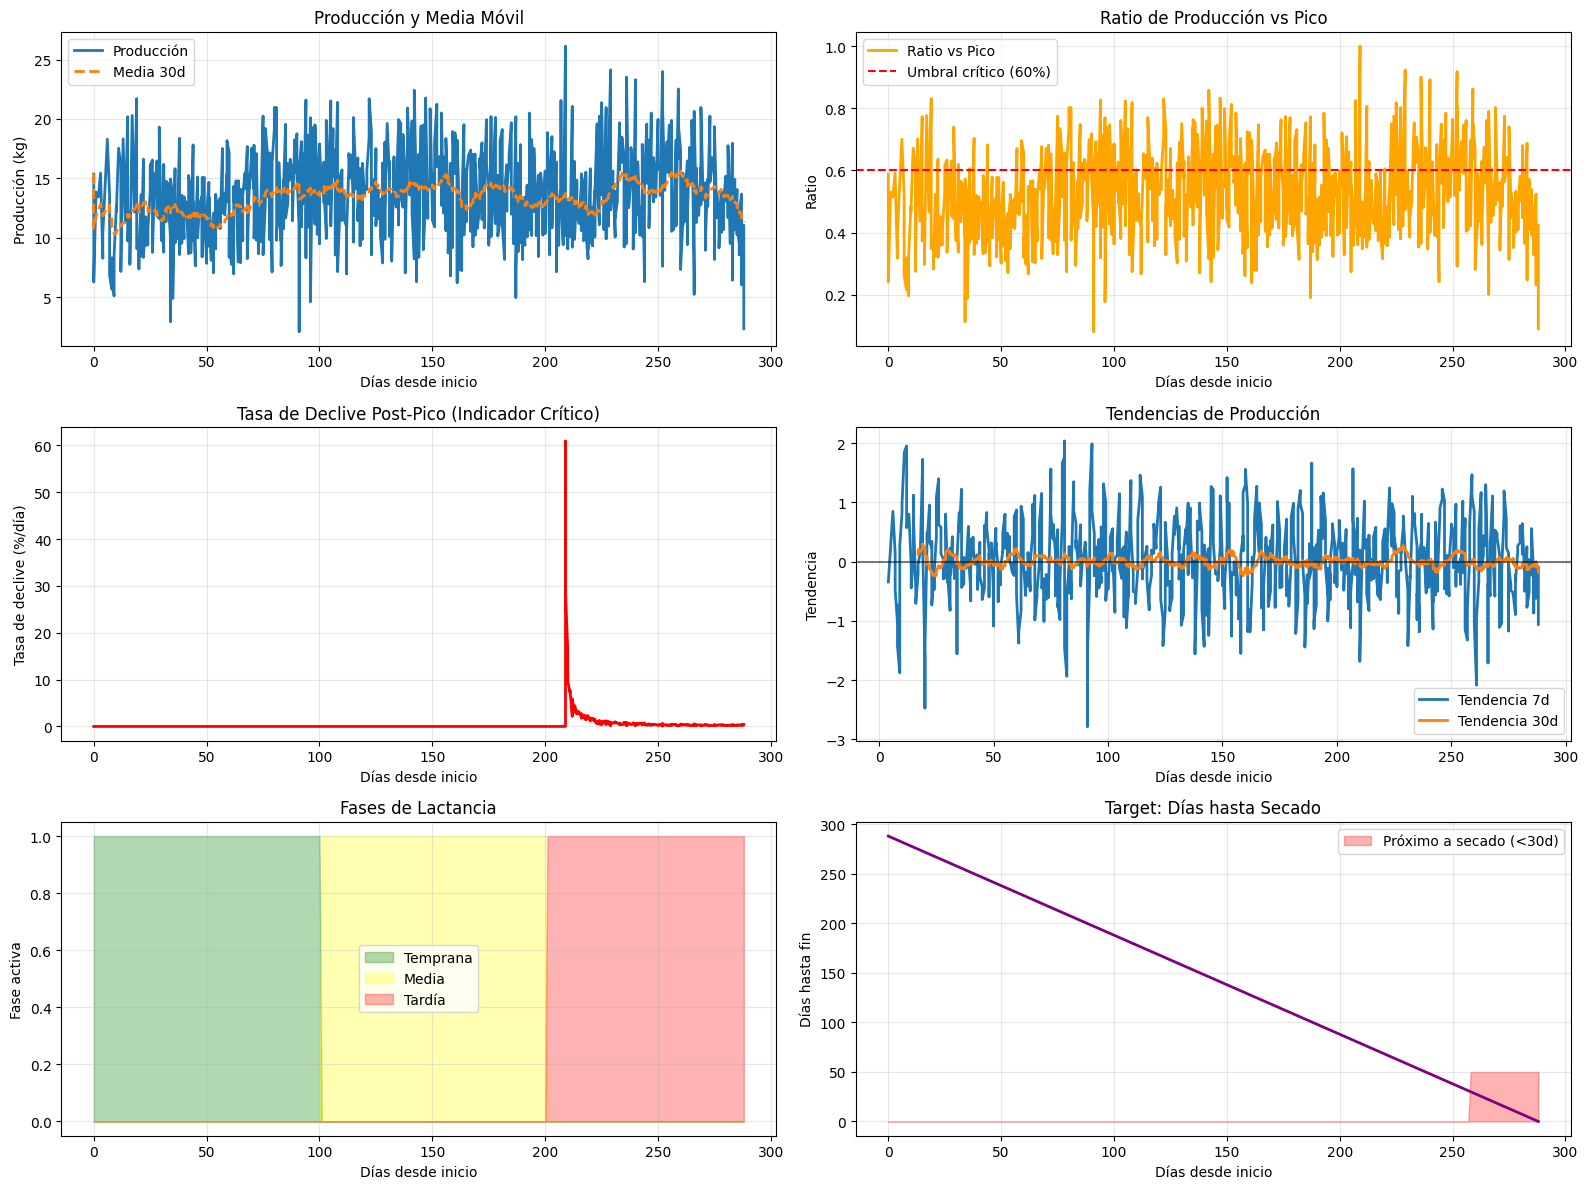

In [ ]:
# 1. Crear el feature engineer
feature_eng = LactationFeatureEngineering(sequence_length=30)

# 2. Preparar datos de TODOS los ciclos
X, y, feature_names, metadata = feature_eng.prepare_dataset_for_all_cycles(resultados_con_ciclos)

# 3. Dividir en train/test
X_train, X_test, y_train, y_test = feature_eng.split_train_test(X, y, test_size=0.2)

# 4. Visualizar features de un ciclo específico (ejemplo)
df_ejemplo = resultados_con_ciclos[5]['df']
df_ciclo_ejemplo = df_ejemplo[df_ejemplo['ciclo'] == 1]
df_features_ejemplo = feature_eng.create_phase_features(df_ciclo_ejemplo)
feature_eng.visualize_feature_importance_over_time(df_features_ejemplo)

# 5. Guardar datos para entrenar el LSTM
np.save('X_train_lstm.npy', X_train)
np.save('X_test_lstm.npy', X_test)
np.save('y_train_lstm.npy', y_train)
np.save('y_test_lstm.npy', y_test)

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

class LactationLSTMModel:
    """
    Modelo LSTM para predecir días hasta el secado basado en patrones de producción.
    """

    def __init__(self, sequence_length, n_features):
        """
        Args:
            sequence_length: Longitud de la secuencia temporal
            n_features: Número de features de entrada
        """
        self.sequence_length = sequence_length
        self.n_features = n_features
        self.model = None
        self.history = None

    def build_model(self, lstm_units=[128, 64, 32], dropout_rate=0.2, learning_rate=0.001):
        """
        Construye la arquitectura del modelo LSTM.
        """
        model = Sequential()

        # Primera capa LSTM con return_sequences=True para apilar más LSTMs
        model.add(layers.LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
        model.add(layers.Dropout(dropout_rate))

        # Capas LSTM adicionales
        for i, units in enumerate(lstm_units[1:]):
            # La última capa LSTM no necesita return_sequences
            return_seq = i < len(lstm_units) - 2
            model.add(layers.LSTM(units, return_sequences=return_seq))
            model.add(layers.Dropout(dropout_rate))

        # Capas densas para la salida
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.Dense(16, activation='relu'))

        # Capa de salida (regresión - predice días hasta secado)
        model.add(layers.Dense(1))

        # Compilar modelo
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(
            optimizer=optimizer,
            loss='huber',  # Robusto a outliers
            metrics=['mae', 'mse']
        )

        self.model = model

        print("="*80)
        print("ARQUITECTURA DEL MODELO")
        print("="*80)
        model.summary()

        return model

    def train(self, X_train, y_train, X_val=None, y_val=None,
              epochs=100, batch_size=32, patience=15):
        """
        Entrena el modelo LSTM.
        """
        if self.model is None:
            raise ValueError("Debes construir el modelo primero con build_model()")

        # Callbacks
        early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss' if X_val is not None else 'loss',
            factor=0.5,
            patience=5,
            min_lr=0.00001,
            verbose=1
        )

        # Entrenar
        validation_data = (X_val, y_val) if X_val is not None else None

        print("\n" + "="*80)
        print("ENTRENANDO MODELO")
        print("="*80)

        self.history = self.model.fit(
            X_train, y_train,
            validation_data=validation_data,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop, reduce_lr],
            verbose=1
        )

        return self.history

    def evaluate(self, X_test, y_test):
        """
        Evalúa el modelo en datos de test.
        """
        print("\n" + "="*80)
        print("EVALUACIÓN EN TEST SET")
        print("="*80)

        # Predicciones
        y_pred = self.model.predict(X_test).flatten()

        # Métricas
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        print(f"\nMétricas de Evaluación:")
        print(f"  MAE (Error Abs. Medio): {mae:.2f} días")
        print(f"  RMSE (Raíz Error Cuad.): {rmse:.2f} días")
        print(f"  R² Score: {r2:.4f}")

        # Análisis de errores
        errors = np.abs(y_test - y_pred)
        print(f"\nDistribución de Errores:")
        print(f"  Error medio: {errors.mean():.2f} días")
        print(f"  Error mediano: {np.median(errors):.2f} días")
        print(f"  Error máximo: {errors.max():.2f} días")
        print(f"  Percentil 95: {np.percentile(errors, 95):.2f} días")

        # Análisis por rangos de días hasta secado
        print(f"\nError por Proximidad al Secado:")
        for rango_min, rango_max in [(0, 30), (31, 60), (61, 120), (121, np.inf)]:
            mask = (y_test >= rango_min) & (y_test < rango_max)
            if mask.sum() > 0:
                rango_errors = errors[mask]
                rango_name = f"{rango_min}-{int(rango_max) if rango_max != np.inf else '+'} días"
                print(f"  {rango_name}: MAE = {rango_errors.mean():.2f} días (n={mask.sum()})")

        return {
            'predictions': y_pred,
            'true_values': y_test,
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'errors': errors
        }

    def plot_training_history(self):
        """
        Visualiza el proceso de entrenamiento.
        """
        if self.history is None:
            print("El modelo no ha sido entrenado aún.")
            return

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Loss
        axes[0].plot(self.history.history['loss'], label='Train Loss', linewidth=2)
        if 'val_loss' in self.history.history:
            axes[0].plot(self.history.history['val_loss'], label='Val Loss', linewidth=2)
        axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
        axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
        axes[0].set_title('Pérdida durante Entrenamiento', fontsize=14, fontweight='bold')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # MAE
        axes[1].plot(self.history.history['mae'], label='Train MAE', linewidth=2)
        if 'val_mae' in self.history.history:
            axes[1].plot(self.history.history['val_mae'], label='Val MAE', linewidth=2)
        axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('MAE (días)', fontsize=12, fontweight='bold')
        axes[1].set_title('Error Absoluto Medio', fontsize=14, fontweight='bold')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_predictions(self, results, sample_size=500):
        """
        Visualiza predicciones vs valores reales.
        """
        y_pred = results['predictions']
        y_test = results['true_values']

        # Tomar muestra si hay muchos datos
        if len(y_test) > sample_size:
            indices = np.random.choice(len(y_test), sample_size, replace=False)
            y_test_sample = y_test[indices]
            y_pred_sample = y_pred[indices]
        else:
            y_test_sample = y_test
            y_pred_sample = y_pred

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # 1. Scatter plot: Predicción vs Real
        axes[0, 0].scatter(y_test_sample, y_pred_sample, alpha=0.5, s=30)

        # Línea de predicción perfecta
        min_val = min(y_test_sample.min(), y_pred_sample.min())
        max_val = max(y_test_sample.max(), y_pred_sample.max())
        axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Predicción perfecta')

        axes[0, 0].set_xlabel('Días Reales hasta Secado', fontsize=12, fontweight='bold')
        axes[0, 0].set_ylabel('Días Predichos hasta Secado', fontsize=12, fontweight='bold')
        axes[0, 0].set_title(f'Predicciones vs Valores Reales (R²={results["r2"]:.3f})',
                            fontsize=13, fontweight='bold')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # 2. Distribución de errores
        errors = results['errors']
        axes[0, 1].hist(errors, bins=50, edgecolor='black', alpha=0.7, color='coral')
        axes[0, 1].axvline(errors.mean(), color='red', linestyle='--', linewidth=2,
                          label=f'Media: {errors.mean():.1f}d')
        axes[0, 1].axvline(np.median(errors), color='green', linestyle='--', linewidth=2,
                          label=f'Mediana: {np.median(errors):.1f}d')
        axes[0, 1].set_xlabel('Error Absoluto (días)', fontsize=12, fontweight='bold')
        axes[0, 1].set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
        axes[0, 1].set_title('Distribución de Errores', fontsize=13, fontweight='bold')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3, axis='y')

        # 3. Error vs Días hasta secado
        axes[1, 0].scatter(y_test, errors, alpha=0.5, s=30, color='purple')
        axes[1, 0].axhline(errors.mean(), color='red', linestyle='--', linewidth=2)
        axes[1, 0].set_xlabel('Días Reales hasta Secado', fontsize=12, fontweight='bold')
        axes[1, 0].set_ylabel('Error Absoluto (días)', fontsize=12, fontweight='bold')
        axes[1, 0].set_title('Error vs Proximidad al Secado', fontsize=13, fontweight='bold')
        axes[1, 0].grid(True, alpha=0.3)

        # 4. Predicciones en serie temporal (muestra)
        sample_indices = np.arange(min(200, len(y_test)))
        axes[1, 1].plot(sample_indices, y_test[sample_indices],
                       label='Real', marker='o', linewidth=2, markersize=4)
        axes[1, 1].plot(sample_indices, y_pred[sample_indices],
                       label='Predicción', marker='x', linewidth=2, markersize=4, alpha=0.7)
        axes[1, 1].fill_between(sample_indices,
                               y_test[sample_indices] - errors[sample_indices],
                               y_test[sample_indices] + errors[sample_indices],
                               alpha=0.2, color='gray', label='±Error')
        axes[1, 1].set_xlabel('Índice de muestra', fontsize=12, fontweight='bold')
        axes[1, 1].set_ylabel('Días hasta Secado', fontsize=12, fontweight='bold')
        axes[1, 1].set_title('Predicciones en Serie Temporal (primeras 200)',
                            fontsize=13, fontweight='bold')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def predict_future(self, X_last_sequence):
        """
        Predice días hasta secado para una nueva secuencia.

        Args:
            X_last_sequence: Array de shape (1, sequence_length, n_features)
        """
        if self.model is None:
            raise ValueError("El modelo no ha sido construido.")

        prediction = self.model.predict(X_last_sequence, verbose=0)
        return prediction[0][0]

    def save_model(self, filepath='lactation_lstm_model.h5'):
        """
        Guarda el modelo entrenado.
        """
        if self.model is None:
            raise ValueError("No hay modelo para guardar.")

        self.model.save(filepath)
        print(f"✓ Modelo guardado en: {filepath}")

    def load_model(self, filepath='lactation_lstm_model.h5'):
        """
        Carga un modelo previamente entrenado.
        """
        self.model = keras.models.load_model(filepath)
        print(f"✓ Modelo cargado desde: {filepath}")

PREPARANDO DATOS PARA LSTM

Procesando Animal 0001...
  ✓ Ciclo 1: 432 secuencias generadas

Procesando Animal 0002...
  ✓ Ciclo 1: 519 secuencias generadas
  ✓ Ciclo 2: 498 secuencias generadas

Procesando Animal 0003...
  ✓ Ciclo 1: 431 secuencias generadas

Procesando Animal 0004...
  ✓ Ciclo 1: 456 secuencias generadas
  ✓ Ciclo 2: 653 secuencias generadas

Procesando Animal 0005...
  ✓ Ciclo 1: 635 secuencias generadas
  ✓ Ciclo 2: 429 secuencias generadas

Procesando Animal 0006...
  ✓ Ciclo 1: 753 secuencias generadas

Procesando Animal 0013...
  ✓ Ciclo 1: 421 secuencias generadas
  ✓ Ciclo 2: 776 secuencias generadas
  ✓ Ciclo 3: 772 secuencias generadas

Procesando Animal 0014...
  ✓ Ciclo 1: 565 secuencias generadas
  ✓ Ciclo 2: 845 secuencias generadas
  ✓ Ciclo 3: 759 secuencias generadas

Procesando Animal 0015...
  ✗ Error en ciclo 1: Input X contains infinity or a value too large for dtype('float64').
  ✓ Ciclo 2: 400 secuencias generadas
  ✓ Ciclo 3: 344 secuencias gen

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


ENTRENANDO MODELO
Epoch 1/15
817/817 ━━━━━━━━━━━━━━━━━━━━ 94s 103ms/step - loss: 75.6300 - mae: 76.1286 - mse: 9431.3213 - val_loss: 58.7215 - val_mae: 59.2196 - val_mse: 5283.5791 - learning_rate: 0.0010
Epoch 2/15
817/817 ━━━━━━━━━━━━━━━━━━━━ 143s 105ms/step - loss: 56.5030 - mae: 57.0010 - mse: 5140.4404 - val_loss: 32.1403 - val_mae: 32.6365 - val_mse: 1896.8842 - learning_rate: 0.0010
Epoch 3/15
817/817 ━━━━━━━━━━━━━━━━━━━━ 143s 106ms/step - loss: 38.2722 - mae: 38.7691 - mse: 2552.2937 - val_loss: 25.3330 - val_mae: 25.8286 - val_mse: 1160.6100 - learning_rate: 0.0010
Epoch 4/15
817/817 ━━━━━━━━━━━━━━━━━━━━ 142s 106ms/step - loss: 34.5017 - mae: 34.9986 - mse: 2121.8445 - val_loss: 23.4246 - val_mae: 23.9203 - val_mse: 967.1296 - learning_rate: 0.0010
Epoch 5/15
817/817 ━━━━━━━━━━━━━━━━━━━━ 84s 103ms/step - loss: 32.8059 - mae: 33.3021 - mse: 1946.1406 - val_loss: 23.6038 - val_mae: 24.0996 - val_mse: 961.6519 - learning_rate: 0.0010
Epoch 6/15
817/817 ━━━━━━━━━━━━━━━━━━━━ 86s 1

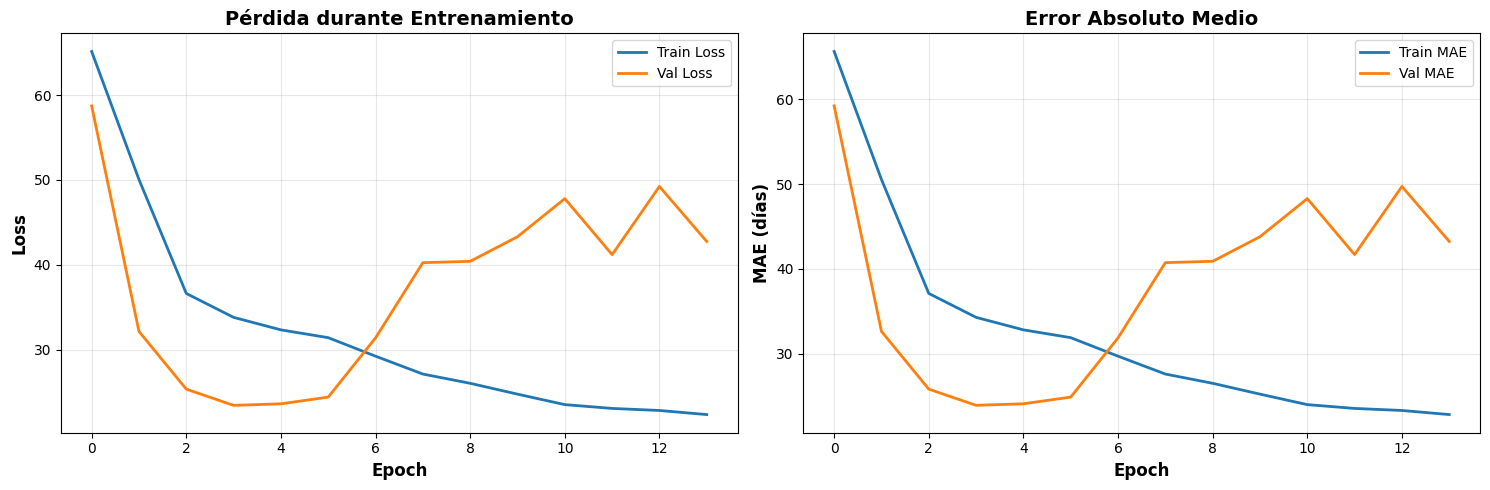


EVALUACIÓN EN TEST SET
205/205 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step

Métricas de Evaluación:
  MAE (Error Abs. Medio): 23.92 días
  RMSE (Raíz Error Cuad.): 31.10 días
  R² Score: 0.8145

Distribución de Errores:
  Error medio: 23.92 días
  Error mediano: 19.00 días
  Error máximo: 126.68 días
  Percentil 95: 64.08 días

Error por Proximidad al Secado:
  0-30 días: MAE = 20.46 días (n=924)
  31-60 días: MAE = 14.00 días (n=918)
  61-120 días: MAE = 18.07 días (n=1833)
  121-+ días: MAE = 32.46 días (n=2767)


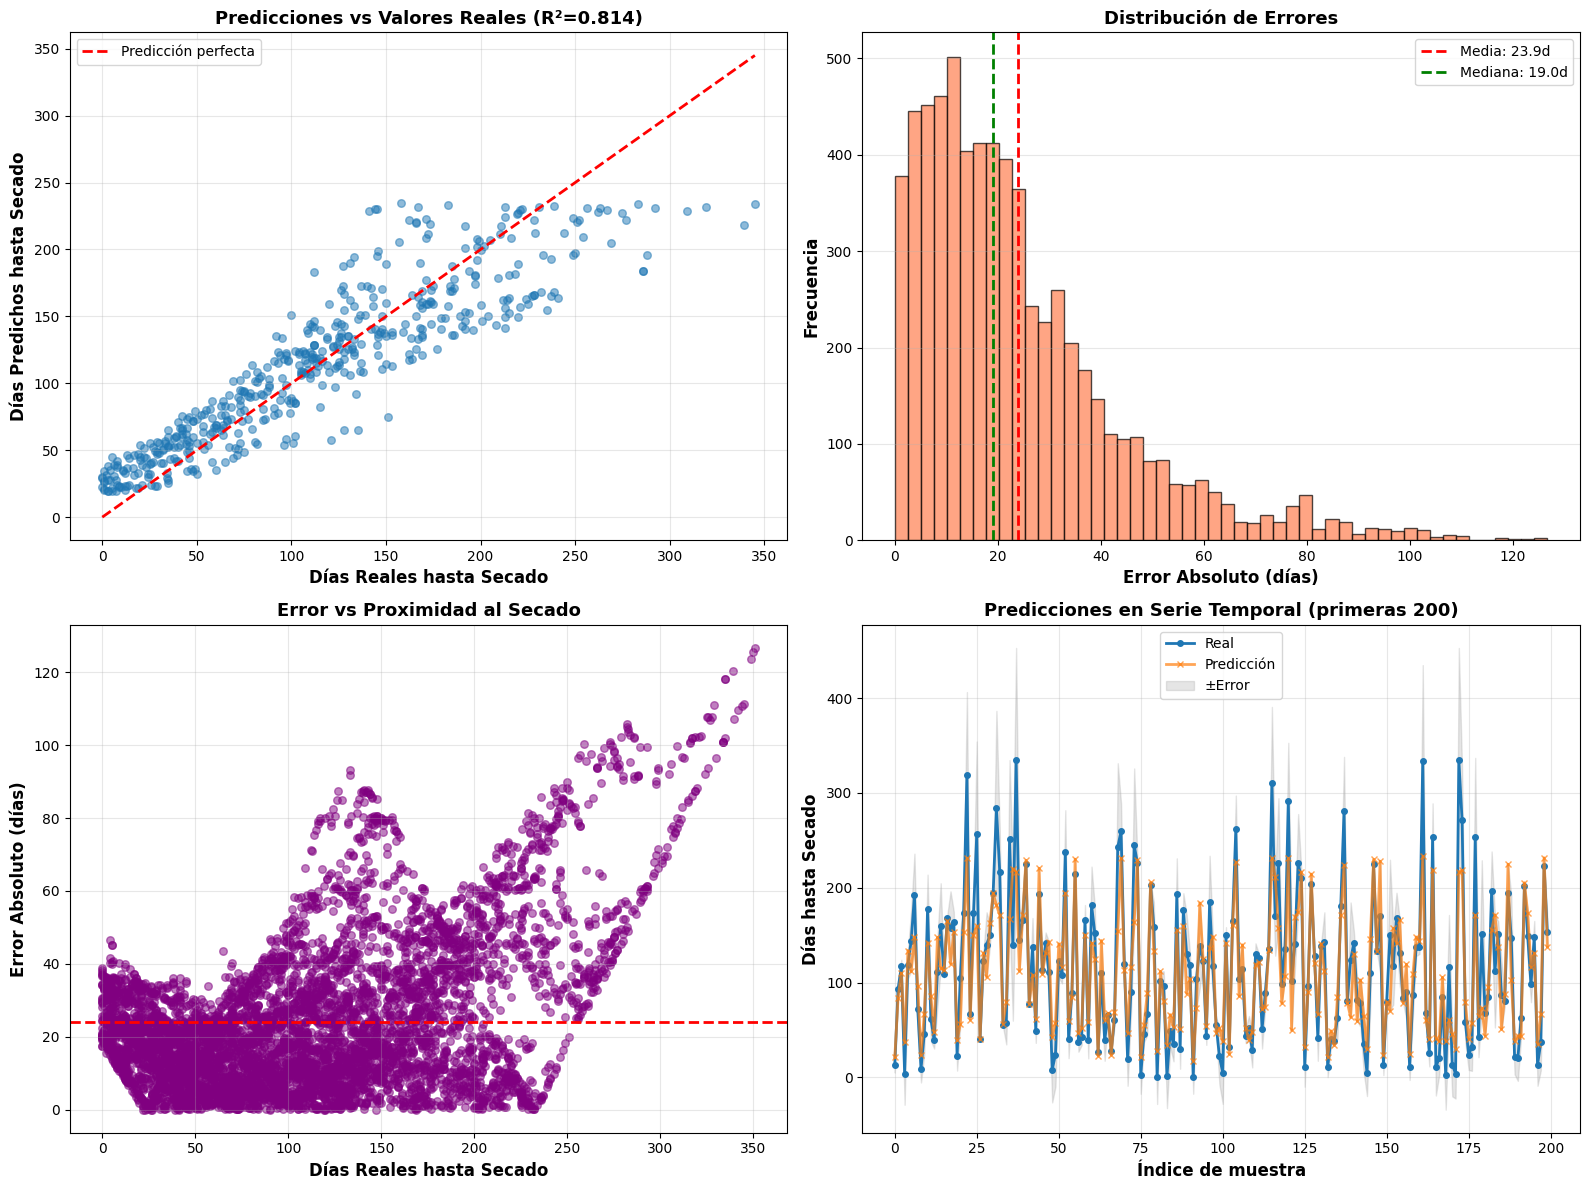

✓ Modelo guardado en: holstein_lactation_predictor.h5


In [ ]:
# Ejemplo de uso completo:
# 1. Preparar datos (ya hecho con LactationFeatureEngineering)
feature_eng = LactationFeatureEngineering(sequence_length=30)
X, y, feature_names, metadata = feature_eng.prepare_dataset_for_all_cycles(resultados_con_ciclos)
X_train, X_test, y_train, y_test = feature_eng.split_train_test(X, y, test_size=0.2)

# 2. Crear y entrenar el modelo
lstm_model = LactationLSTMModel(
    sequence_length=30,
    n_features=X_train.shape[2]
)

# Construir arquitectura
lstm_model.build_model(
    lstm_units=[128, 64, 32],
    dropout_rate=0.3,
    learning_rate=0.001
)

# Entrenar
lstm_model.train(
    X_train, y_train,
    X_val=X_test, y_val=y_test,
    epochs=15,
    batch_size=32,
    patience=15
)

# 3. Visualizar entrenamiento
lstm_model.plot_training_history()

# 4. Evaluar
results = lstm_model.evaluate(X_test, y_test)

# 5. Visualizar predicciones
lstm_model.plot_predictions(results)

# 6. Guardar modelo
lstm_model.save_model('holstein_lactation_predictor.h5')

In [ ]:
def etiquetar_eficiencia(df, umbral_rojo=(0.9, 0.0, 240), umbral_ambar=(1.0, 0.0, 200)):
    """
    Devuelve banda ROJO/ÁMBAR/VERDE:
    - ROJO: kg/min < 0.9, slope <= 0, DIM >= 240
    - ÁMBAR: kg/min < 1.0, slope <= 0, DIM >= 200 (y no es ROJO)
    - VERDE: resto
    """
    df = df.copy()
    rojo = (df['kg_por_min'] < umbral_rojo[0]) & (df['kg_slope_w6'].fillna(0) <= umbral_rojo[1]) & (df['DIM'] >= umbral_rojo[2])
    ambar = (df['kg_por_min'] < umbral_ambar[0]) & (df['kg_slope_w6'].fillna(0) <= umbral_ambar[1]) & (df['DIM'] >= umbral_ambar[2]) & (~rojo)
    verde = ~(rojo | ambar)
    df['eficiencia_band'] = np.select([rojo, ambar, verde], ['ROJO','ÁMBAR','VERDE'])
    return df

# Ranking (últimas 10 ordeñas por vaca)
if not df_modelo.empty:
    rank_rows = []
    for vaca, g in df_modelo.groupby('vaca_id'):
        g = g.sort_values('fecha')
        g = etiquetar_eficiencia(g)
        tail = g.tail(10)
        # Score simple: castigar kg/min bajo y pendiente negativa
        score = (1.0 - tail['kg_por_min'].clip(0,2)/2.0) + (-tail['kg_slope_w6'].fillna(0)).clip(lower=0)
        rank_rows.append({
            'vaca_id': vaca,
            'mean_kg': tail['Producción (kg)'].mean(),
            'mean_kgmin': tail['kg_por_min'].mean(),
            'mean_slope': tail['kg_slope_w6'].mean(),
            'pct_rojo': (tail['eficiencia_band']=='ROJO').mean(),
            'pct_ambar': (tail['eficiencia_band']=='ÁMBAR').mean(),
            'score_baja_ef': score.mean()
        })

    ranking = pd.DataFrame(rank_rows).sort_values(['pct_rojo','score_baja_ef','mean_kgmin'], ascending=[False, False, True])
    print("TOP candidatas por baja eficiencia (considerar secado/mover):")
    display(ranking.head(15))
else:
    print("⚠ df_modelo está vacío; no se puede generar ranking de eficiencia.")
